# Data Preprocessing

In [55]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

In [68]:
def set_dotenv():
    import os
    from dotenv import load_dotenv

    load_dotenv(dotenv_path='variables.env')

    kaggle_username = os.getenv("KAGGLE_USERNAME")
    kaggle_key = os.getenv("KAGGLE_KEY")

    os.environ["KAGGLE_USERNAME"] = kaggle_username
    os.environ["KAGGLE_KEY"] = kaggle_key

def kaggle_download(dataset, output_path='./raw_data/'):
    set_dotenv()

    import kaggle
    import zipfile

    kaggle.api.competition_download_files('house-prices-advanced-regression-techniques', path=output_path)

    with zipfile.ZipFile(f'{output_path}house-prices-advanced-regression-techniques.zip', 'r') as zip_ref:
        zip_ref.extractall(output_path)

def data_target(df, target):
    X = df[list(set(df.columns) - set(target))].drop(columns=[target])
    y = df[target]

    return X, y

def EDA_feat(col, sample=None, size=(24,6)):
    
    if sample is not None:
        if sample < 1:
            col = col.sample(int(sample*len(col)))
        elif sample > 1:
            col = col.sample(int(sample))
        else:
            warnings.warn(f'''Wrong input provided, either pass a fraction such as sample = fraction * df, 
                          either pass the exact number of rows taking in the sample''')
            
    
    plt.subplots(1,3, figsize=size)
    plt.subplot(1,3,1)
    sns.boxplot(col, width=0.2, orient='h')
    plt.ylabel(f'{col.name}')


    plt.subplot(1,3,2)
    sns.histplot(col, stat='density')
    plt.xlabel(f'{col.name}')

    plt.subplot(1,3,3)
    sns.kdeplot(col, label=col.name)
    mean, std_dev = np.mean(col), np.std(col)
    x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
    pdf = norm.pdf(x, mean, std_dev)
    sns.lineplot(x=x, y=pdf, color='b', alpha=0.2, label='Gaussian Distribution')
    # plt.axvline(mean - 3*std_dev, color='r', alpha=0.2)
    # plt.axvline(mean + 3*std_dev, color='r', alpha=0.2)
    # plt.text(mean + 3*std_dev + 0.5, round(col.value_counts(sort=True).max()/len(col),2)/2, "3 $\\sigma$", rotation=90, verticalalignment='center')
    # plt.text(mean - 3*std_dev - 1, round(col.value_counts(sort=True).max()/len(col),2)/2, "-3 $\\sigma$", rotation=90, verticalalignment='center')

    # plt.show()
    # plt.close()


In [69]:
raw_df = pd.read_csv('./raw_data/train.csv') # Local
# df = pd.read_csv('./data/train.csv') # Google collab

raw_df = raw_df.drop(columns=['Id'])

In [70]:
raw_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Duplicates

In [71]:
clean_df = raw_df.copy()
clean_df.duplicated().any()

np.False_

## Imputation

According to the data description file: **MSSubClass** is a categorical class

In [72]:
def count_nulls(df, printing=True, how='absolute'):
    null_counts = df.isnull().sum()
    columns_with_nulls = null_counts[null_counts != 0]

    if not columns_with_nulls.empty:
        if printing == True & how=='absolute':
            print(f'The following features contain NaN values:\n')
            print(columns_with_nulls.to_string(header=False), '\n')
        return list(columns_with_nulls.index)
    
def count_nulls_v2(df):
    null_counts = df.isnull().sum()
    columns_with_nulls = pd.DataFrame(null_counts[null_counts != 0], columns=['missing_values'])
    columns_with_nulls['percentage_missing'] = round(columns_with_nulls['missing_values'] / len(raw_df) * 100, 2)
    
    return columns_with_nulls

def print_unique(df):
    nulls_df = count_nulls_v2(df)

    for col in nulls_df.index:
        if df[col].dtype == 'object':
            print(f'Unique values for the categorical feature {col}:\n{df[col].unique()}')

def impute_df(df, imputing_dict):

    for col, value in imputing_dict.items():
        df[col] = df[col].fillna(value)

    return df

In [73]:
columns_with_nulls = count_nulls_v2(raw_df)
columns_with_nulls

,missing_values,percentage_missing
LotFrontage,259,17.74
Alley,1369,93.77
MasVnrType,872,59.73
MasVnrArea,8,0.55
BsmtQual,37,2.53
BsmtCond,37,2.53
BsmtExposure,38,2.60
BsmtFinType1,37,2.53
BsmtFinType2,38,2.60
Electrical,1,0.07


There are some features that present a large amount of null values, we should study them carefully. Futhermore, Garage features present the same abount of missing values so it is probably that are related

In [74]:
print_unique(clean_df)

Unique values for the categorical feature Alley:
[nan 'Grvl' 'Pave']
Unique values for the categorical feature MasVnrType:
['BrkFace' nan 'Stone' 'BrkCmn']
Unique values for the categorical feature BsmtQual:
['Gd' 'TA' 'Ex' nan 'Fa']
Unique values for the categorical feature BsmtCond:
['TA' 'Gd' nan 'Fa' 'Po']
Unique values for the categorical feature BsmtExposure:
['No' 'Gd' 'Mn' 'Av' nan]
Unique values for the categorical feature BsmtFinType1:
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
Unique values for the categorical feature BsmtFinType2:
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
Unique values for the categorical feature Electrical:
['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
Unique values for the categorical feature FireplaceQu:
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Unique values for the categorical feature GarageType:
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
Unique values for the categorical feature GarageFinish:
['RFn' 'Unf' 'Fin' nan]
Unique values for the categor

It is recommended to spend some time reading the **data_description.txt**. There is valueble content there. Some of the features are displayed like numerical as a simplification but they are meant to be categorical. At the same time, some of the NaN values, could actually have a meaning after it.

This is the case of **Alley** or **Garage**. NaN values there mean that the property doesn't have an alley/garage, so we have to impute it.

In [75]:
# imputing_values = {'Alley': 'NoAlley',
#                    'GarageType': 'NoGarage',
#                    'GarageYrBlt': 'NoGarage',
#                    'GarageFinish': 'NoGarage',
#                    'GarageQual': 'NoGarage',
#                    'GarageCond': 'NoGarage',
#                    'MasVnrType': 'None',
#                    'BsmtQual': 'NoBsmt',
#                    'BsmtCond': 'NoBsmt',
#                    'BsmtExposure': 'NoBsmt',
#                    'BsmtFinType1': 'NoBsmt',
#                    'BsmtFinType2': 'NoBsmt',
#                    'FireplaceQu': 'NoFireplace',
#                    'PoolQC': 'NoPool',
#                    'Fence': 'NoFence',
#                    'MiscFeature': 'None'}


imputing_dict = {'Alley': 'None',
                   'GarageType': 'None',
                   'GarageYrBlt': 'None',
                   'GarageFinish': 'None',
                   'GarageQual': 'None',
                   'GarageCond': 'None',
                   'MasVnrType': 'None',
                   'BsmtQual': 'None',
                   'BsmtCond': 'None',
                   'BsmtExposure': 'None',
                   'BsmtFinType1': 'None',
                   'BsmtFinType2': 'None',
                   'FireplaceQu': 'None',
                   'PoolQC': 'None',
                   'Fence': 'None',
                   'MiscFeature': 'None'}

clean_df = impute_df(clean_df, imputing_dict)
count_nulls_v2(clean_df)


,missing_values,percentage_missing
LotFrontage,259,17.74
MasVnrArea,8,0.55
Electrical,1,0.07


## Outliers

C:\Users\roriesco2201\AppData\Local\Temp\1\ipykernel_20904\2868586505.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.subplots(1,3, figsize=size)


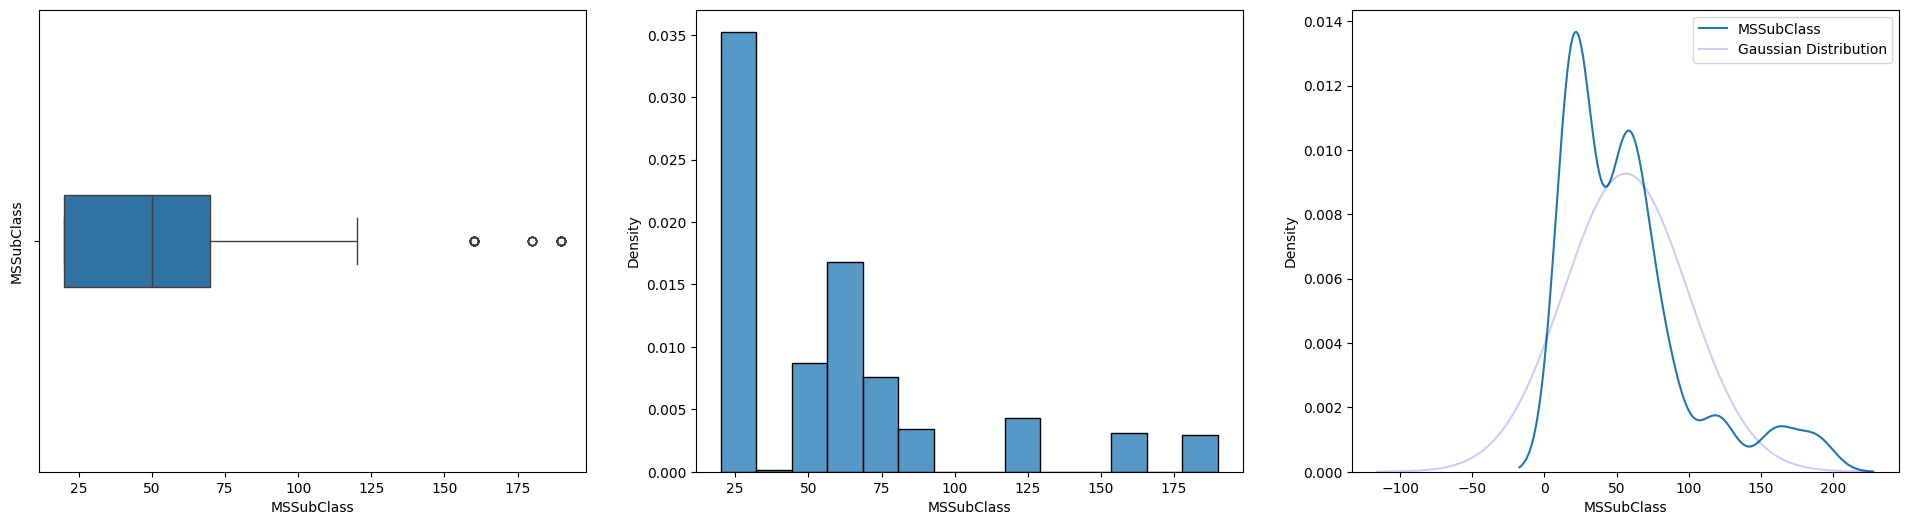

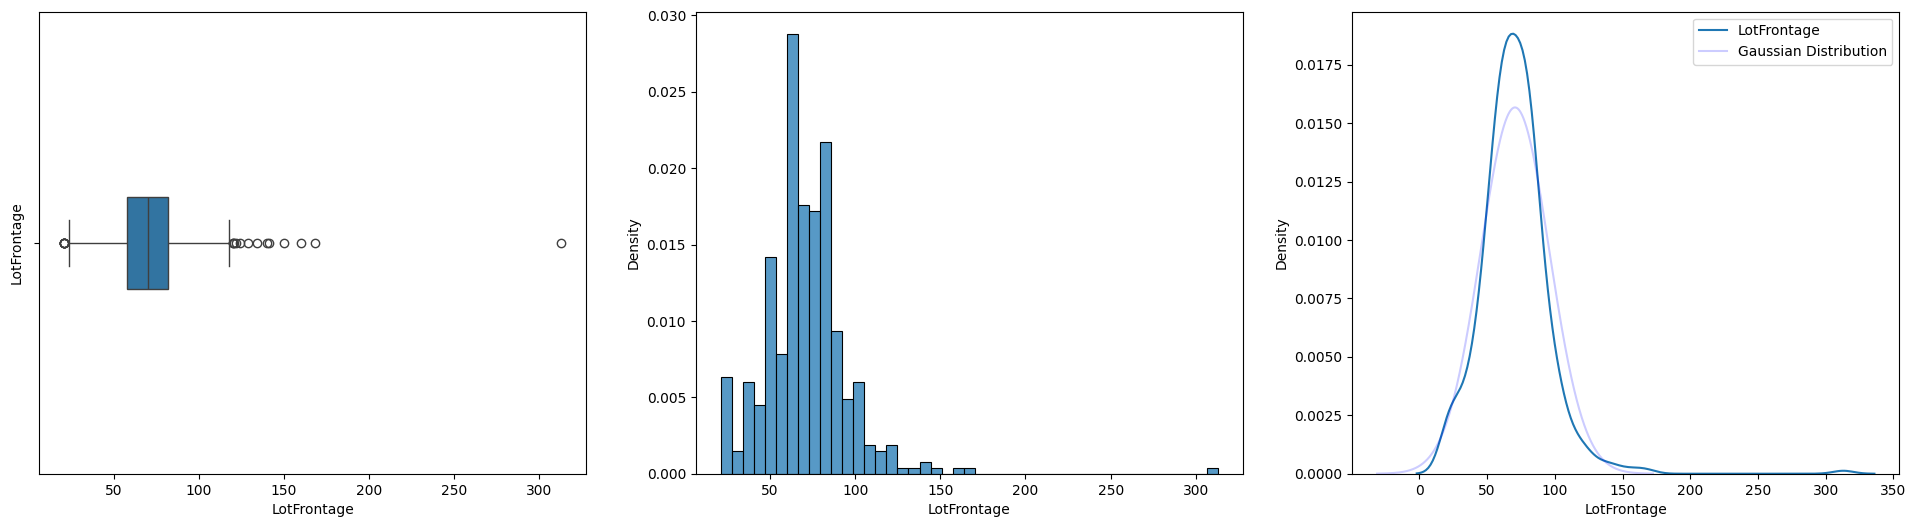

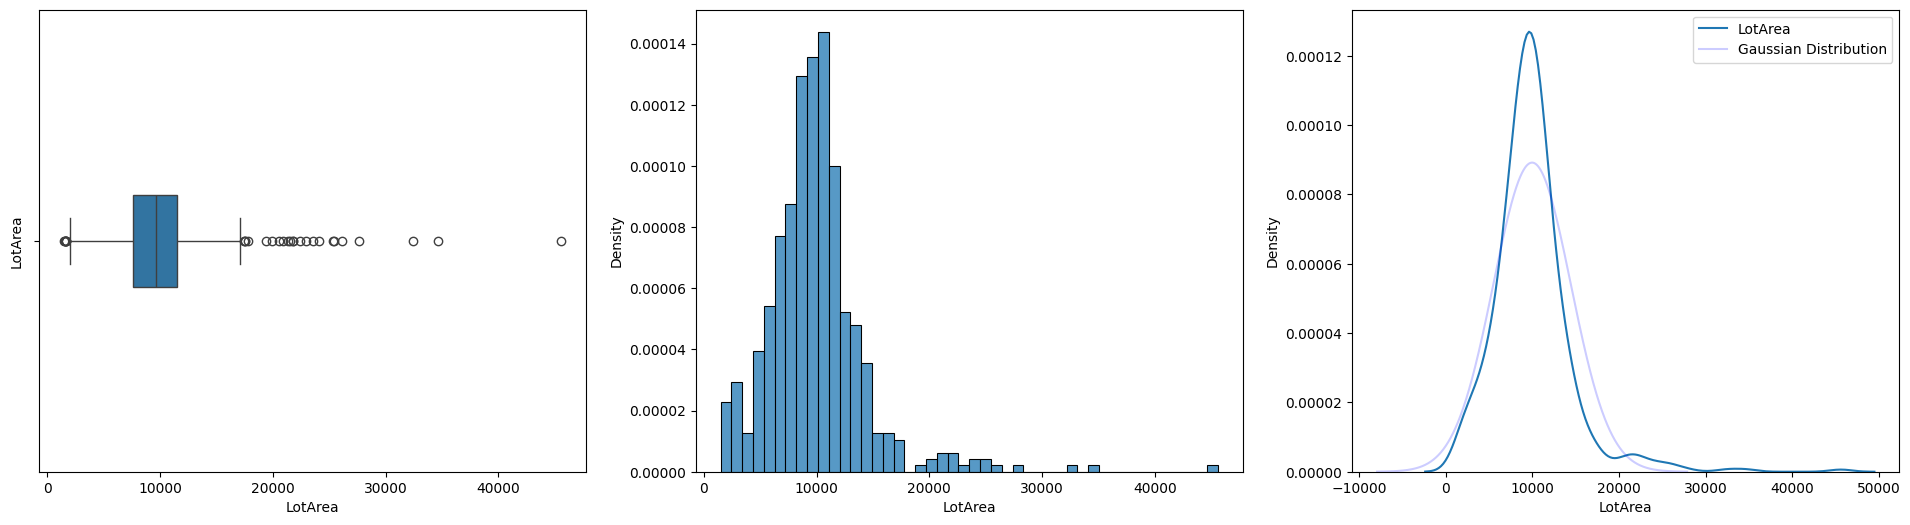

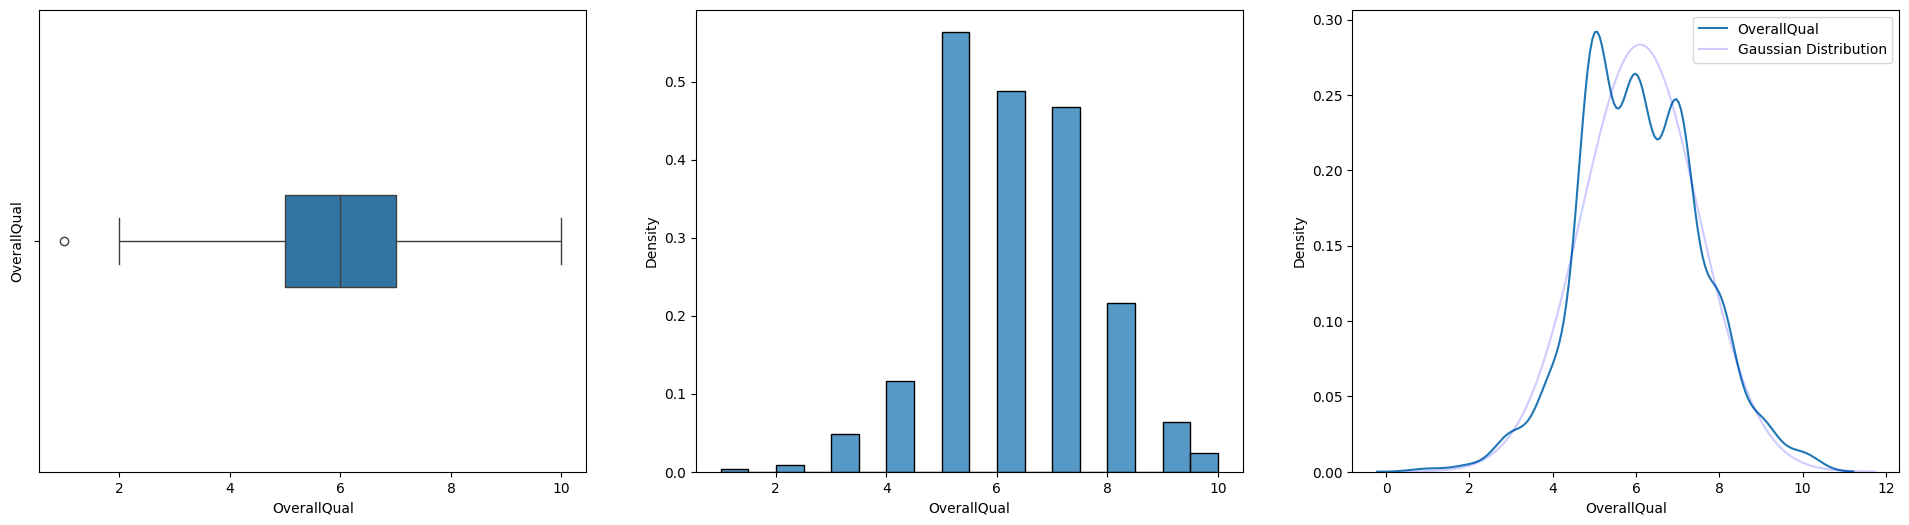

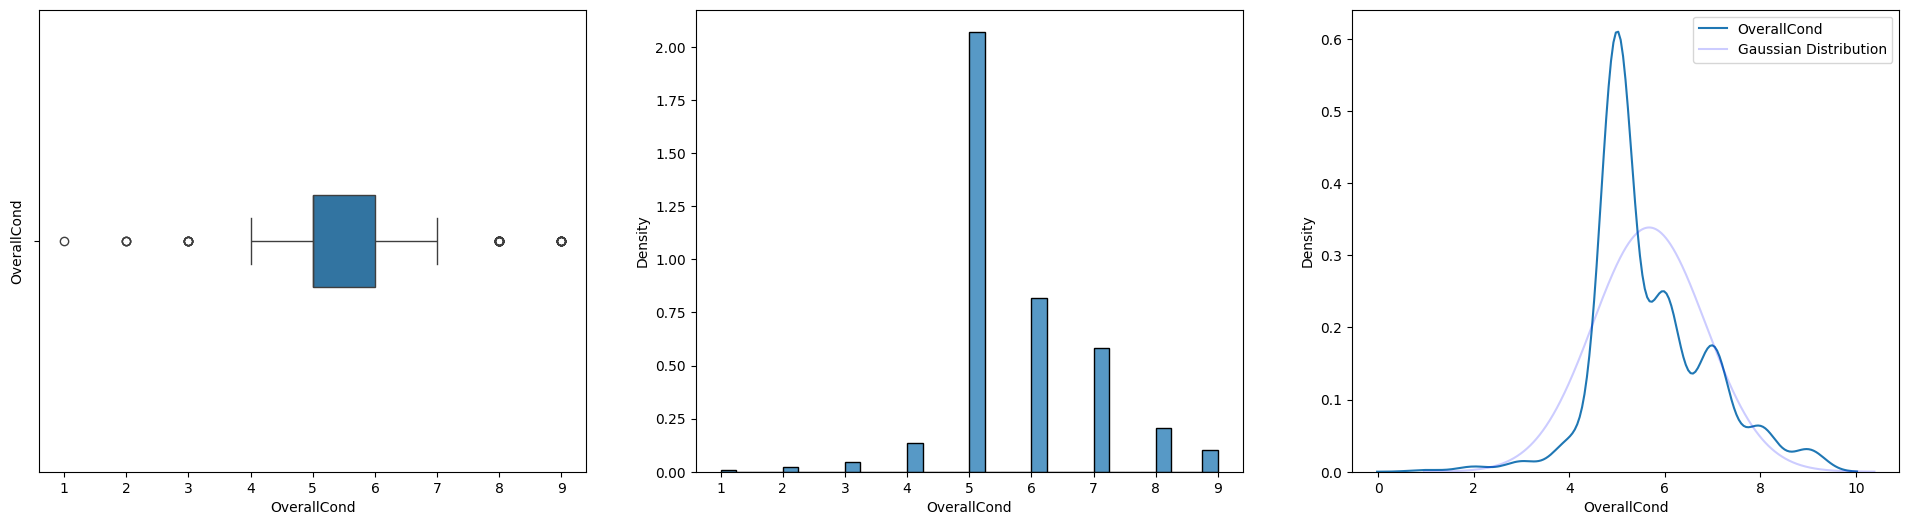

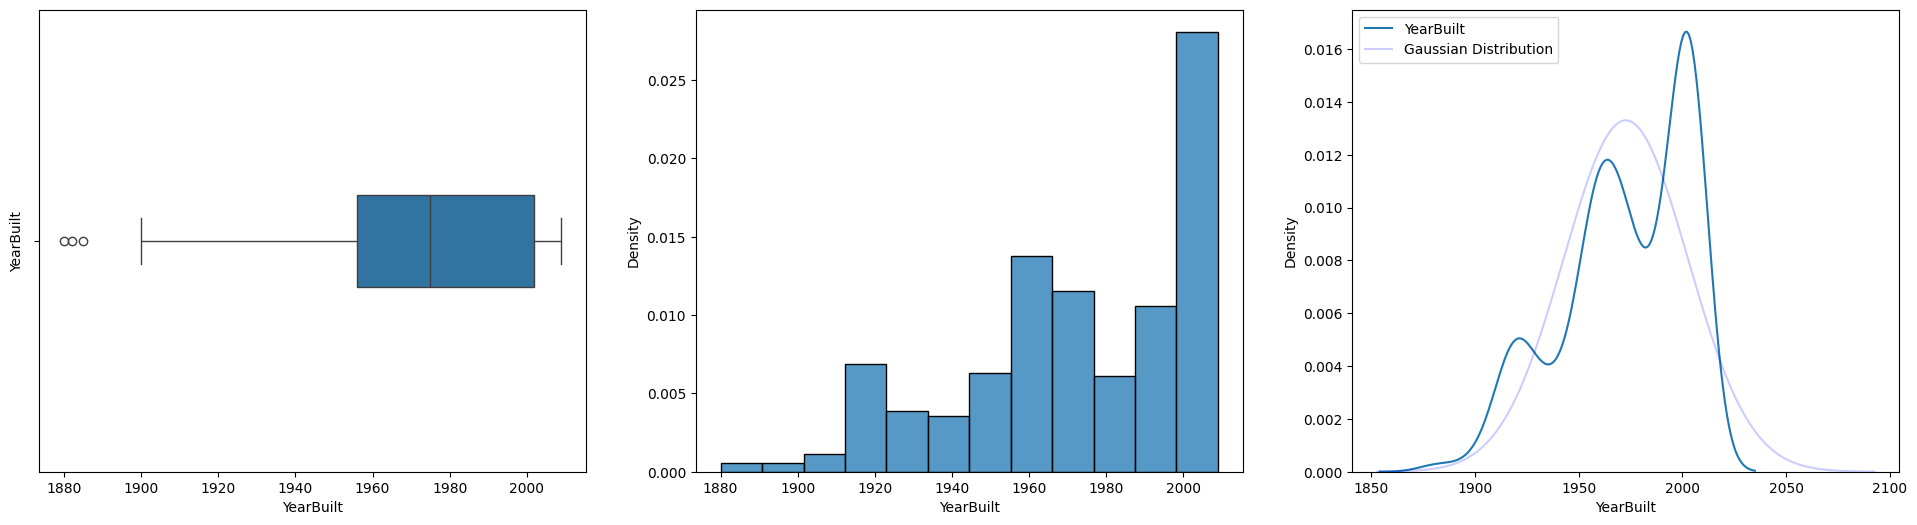

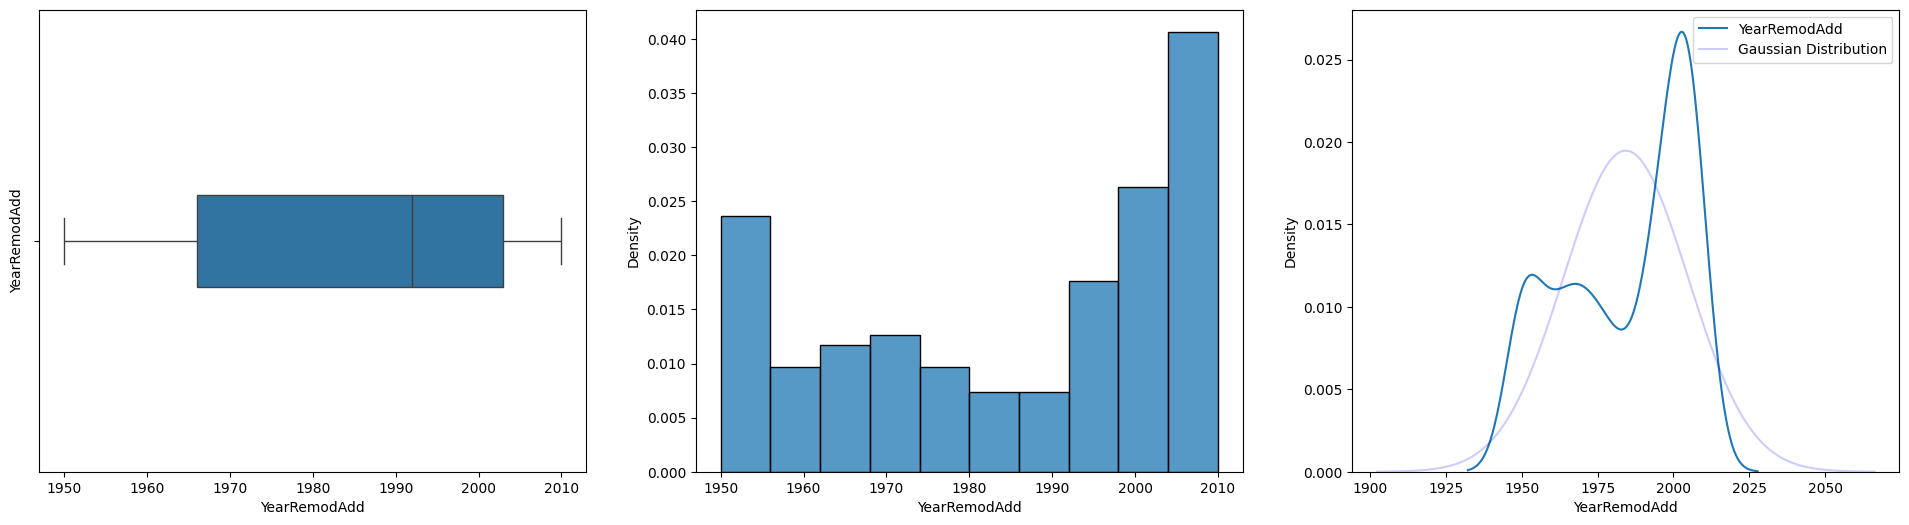

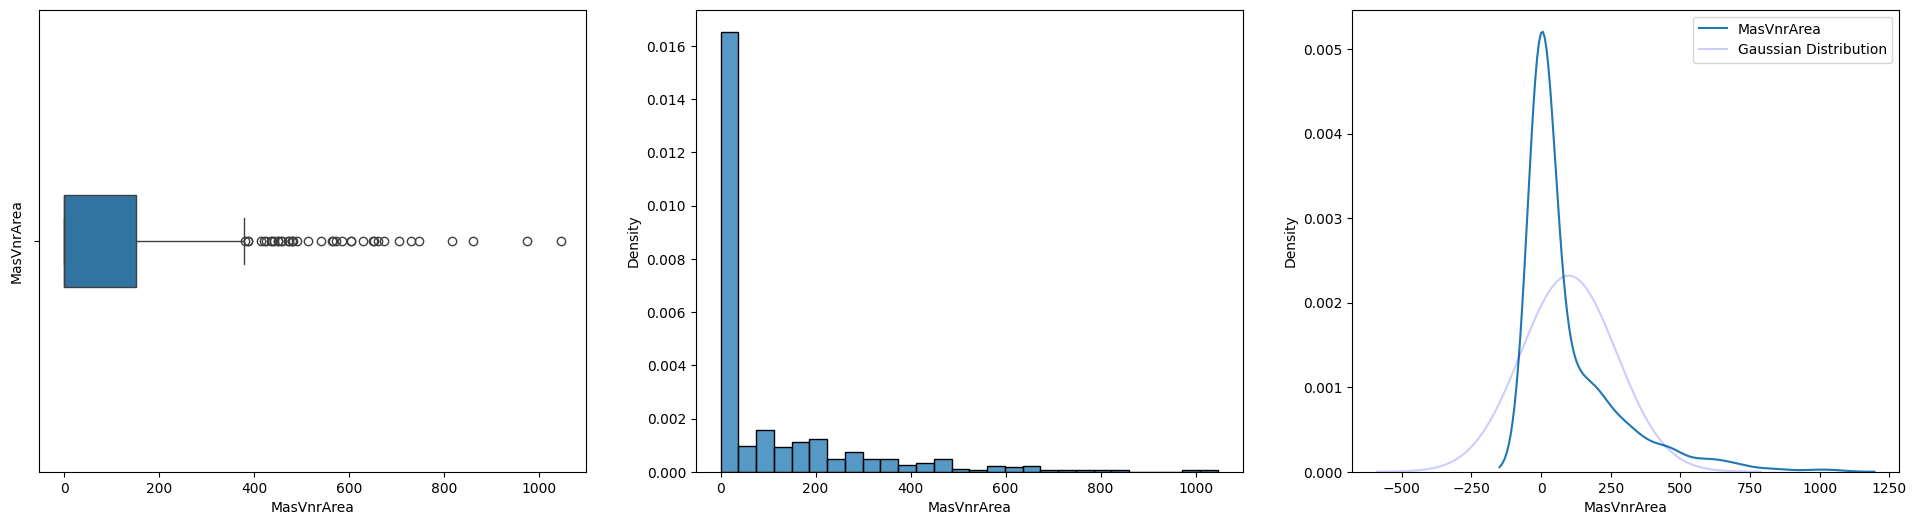

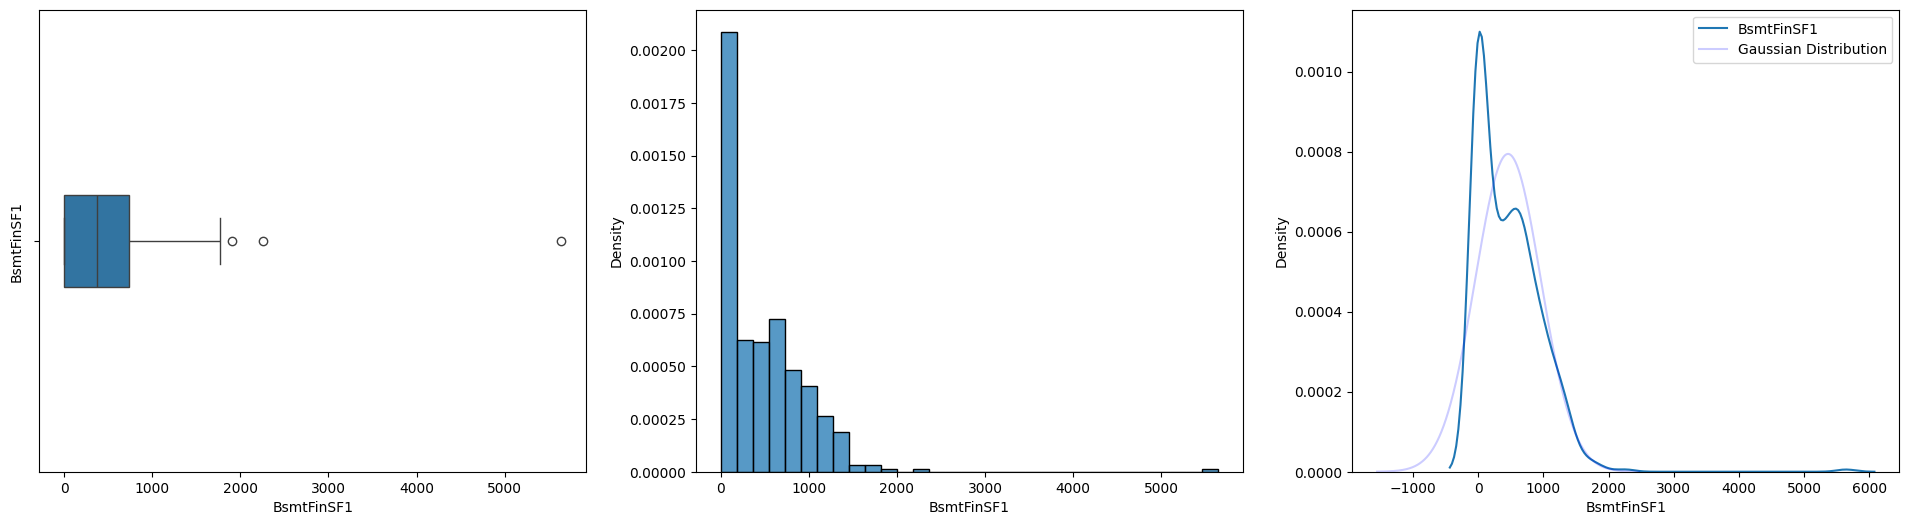

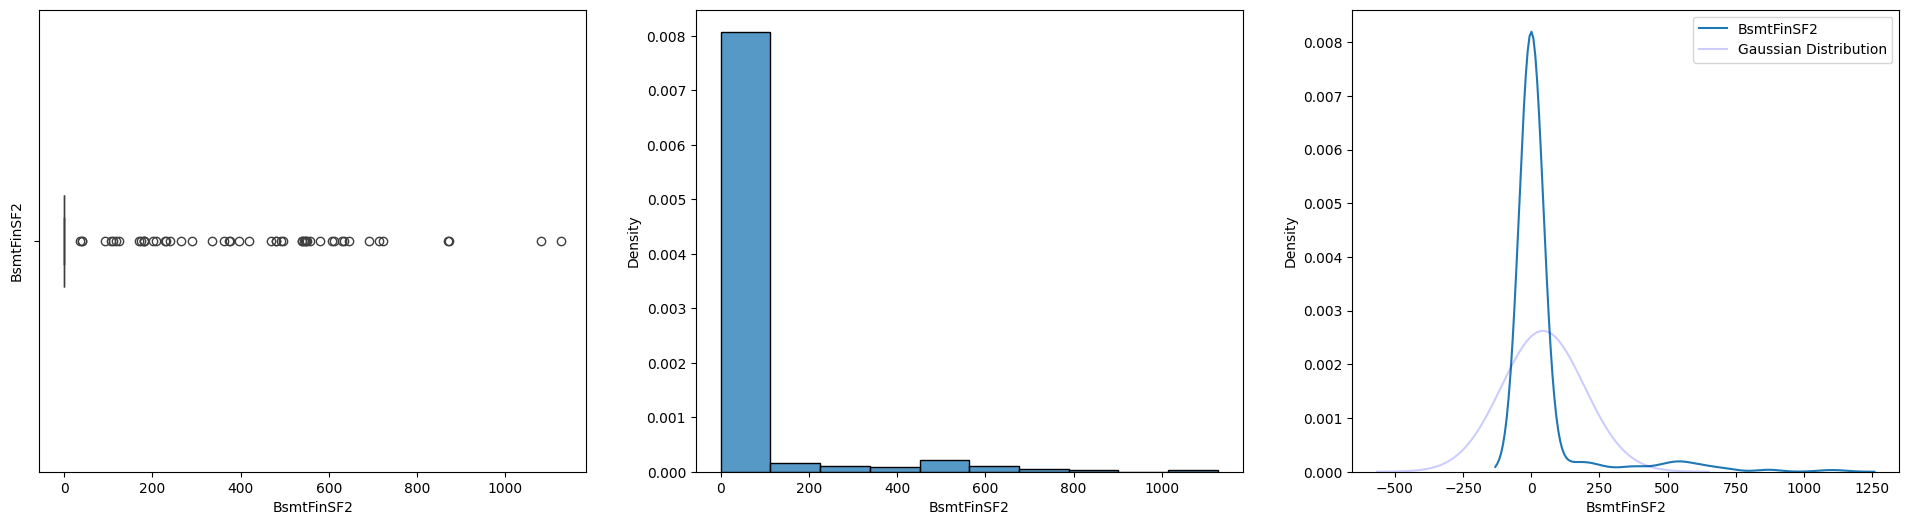

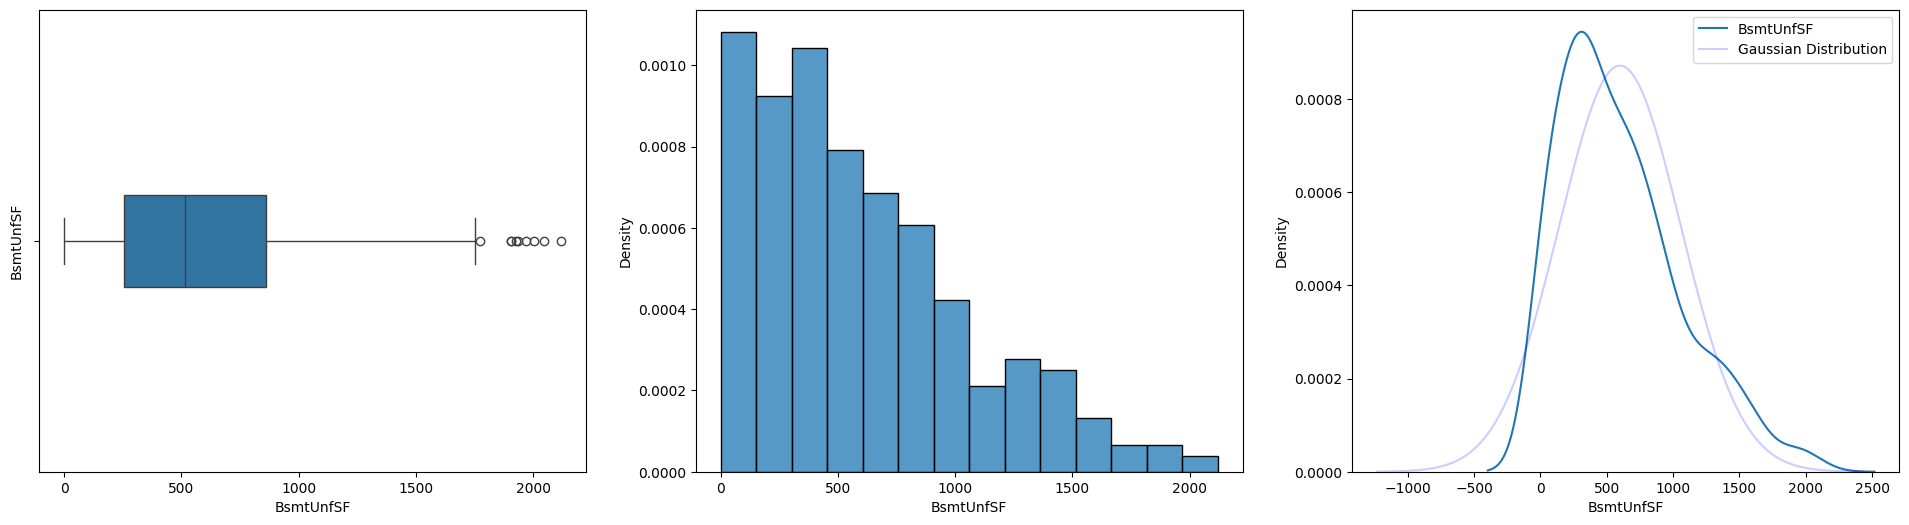

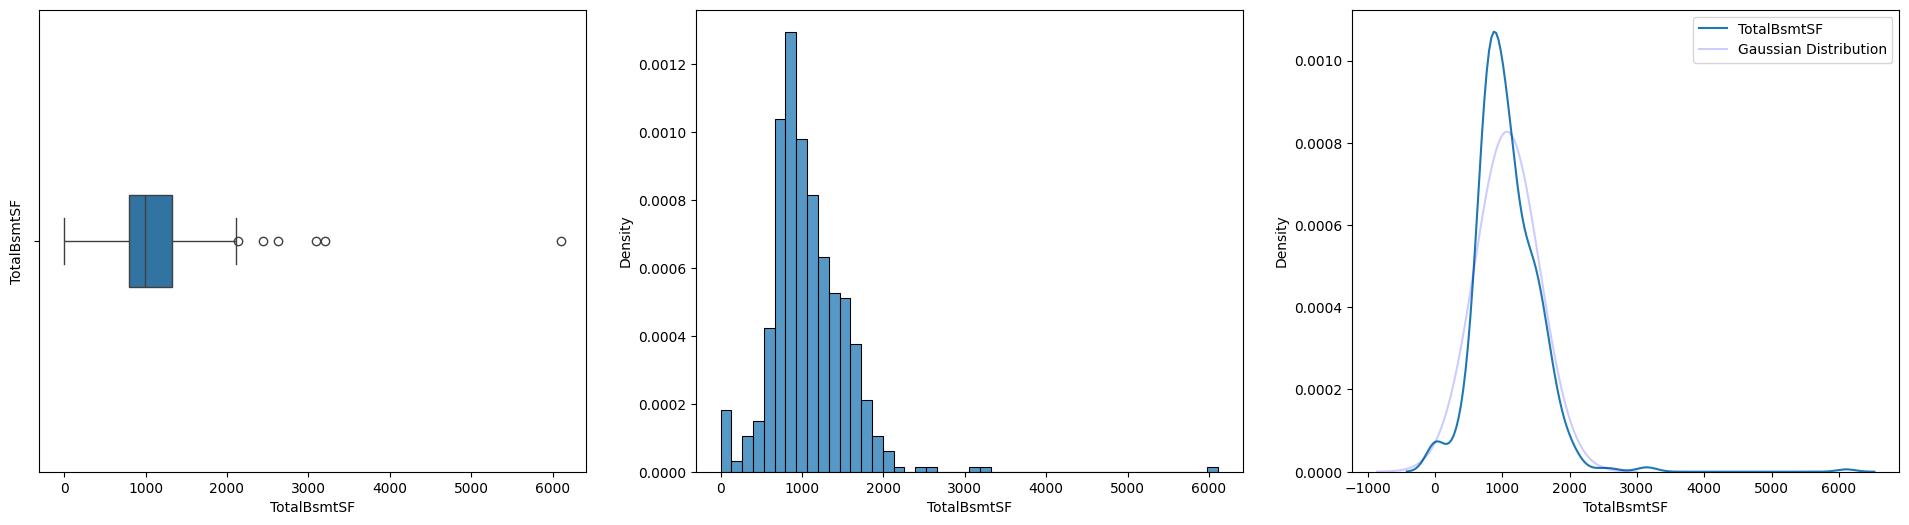

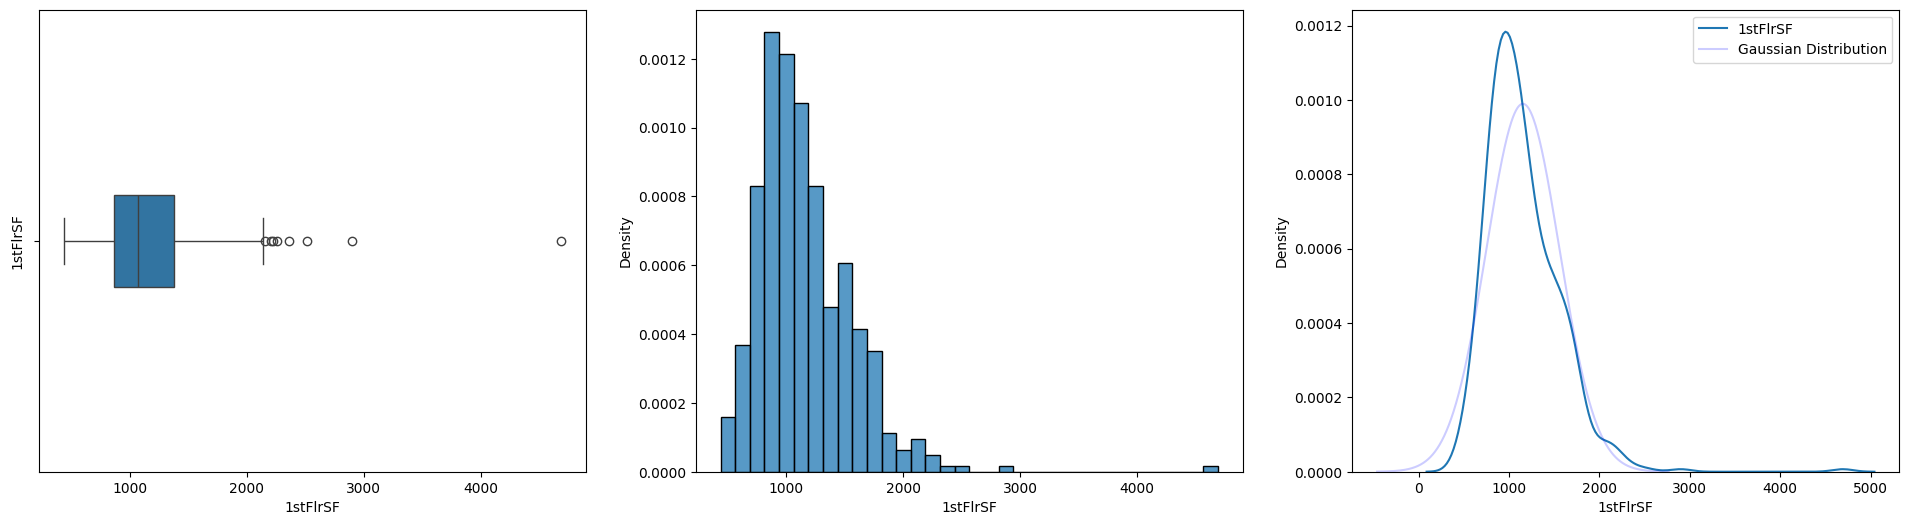

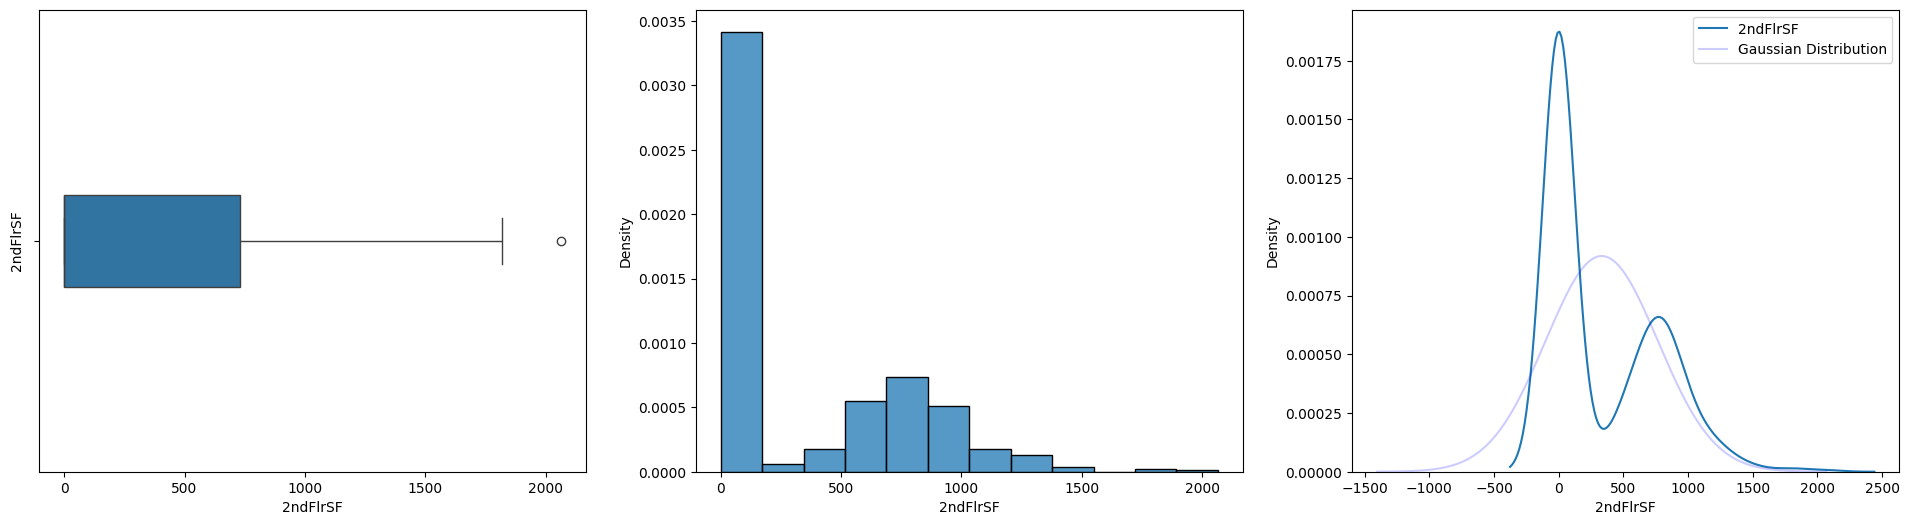

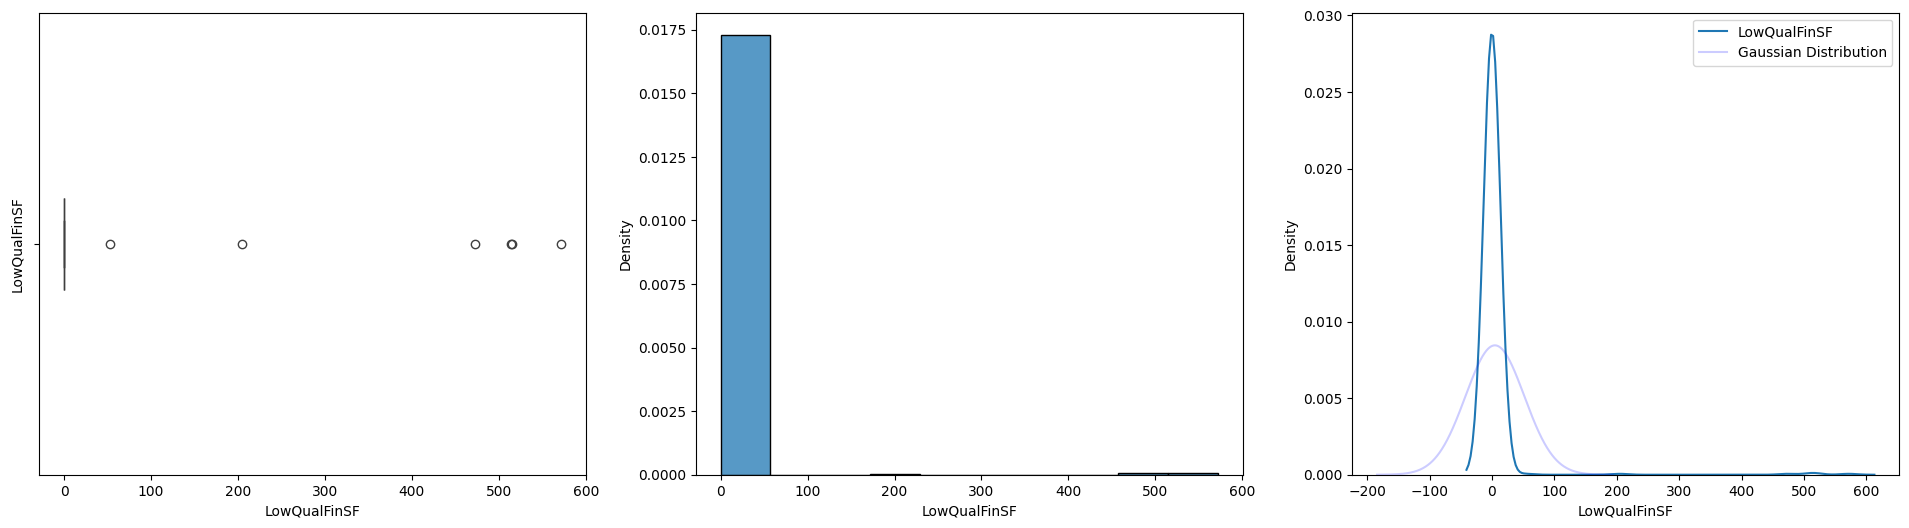

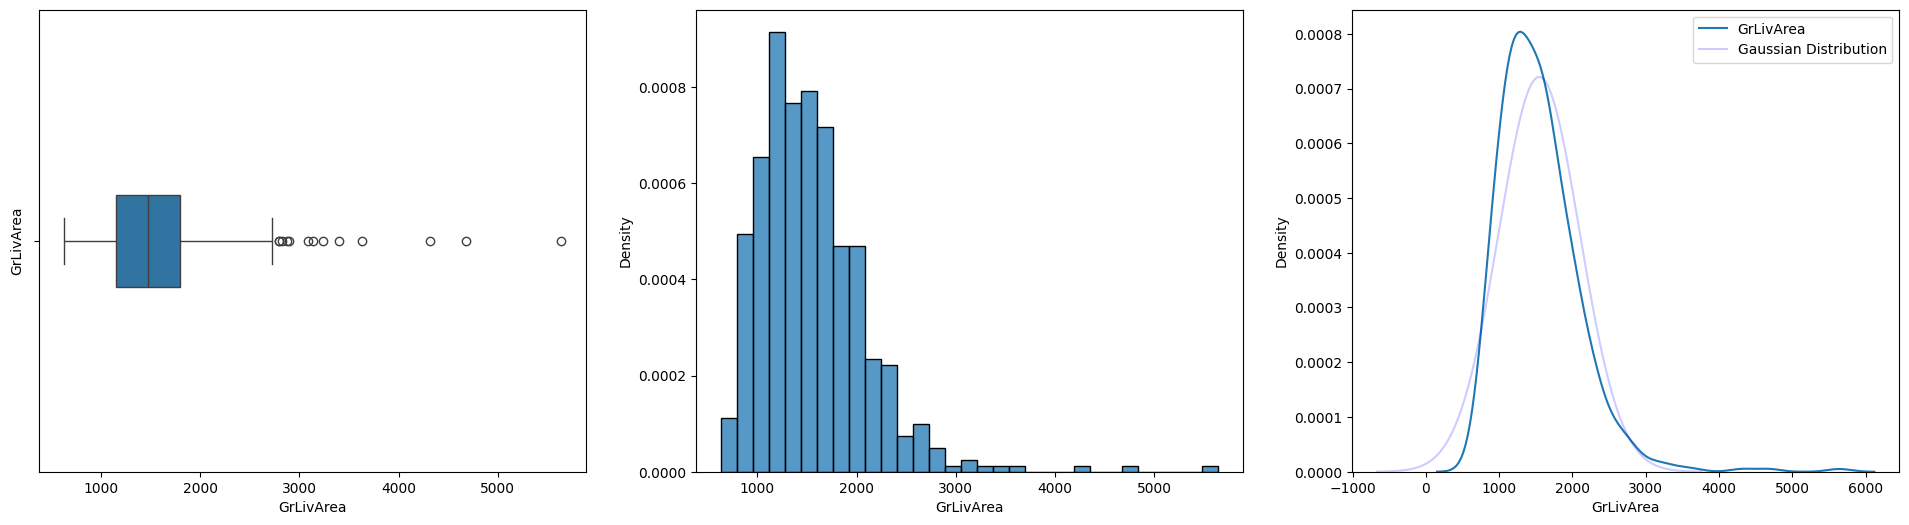

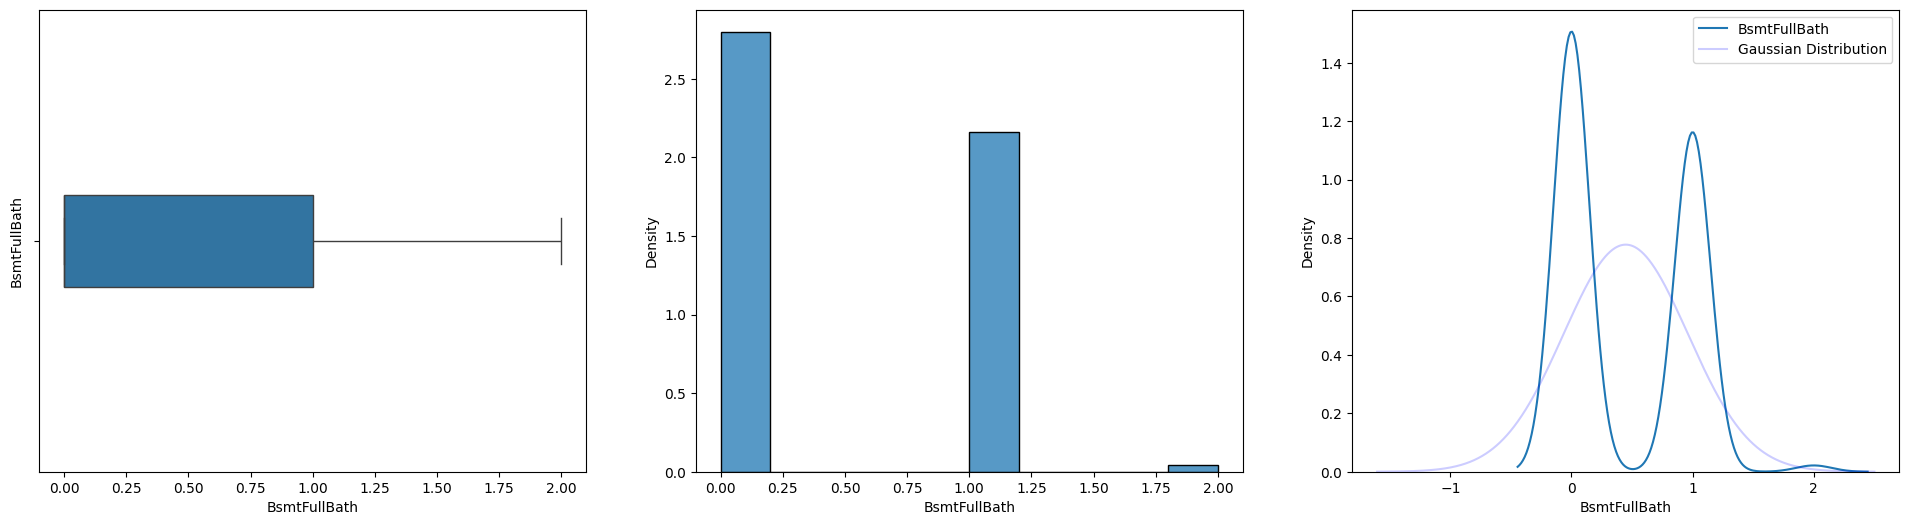

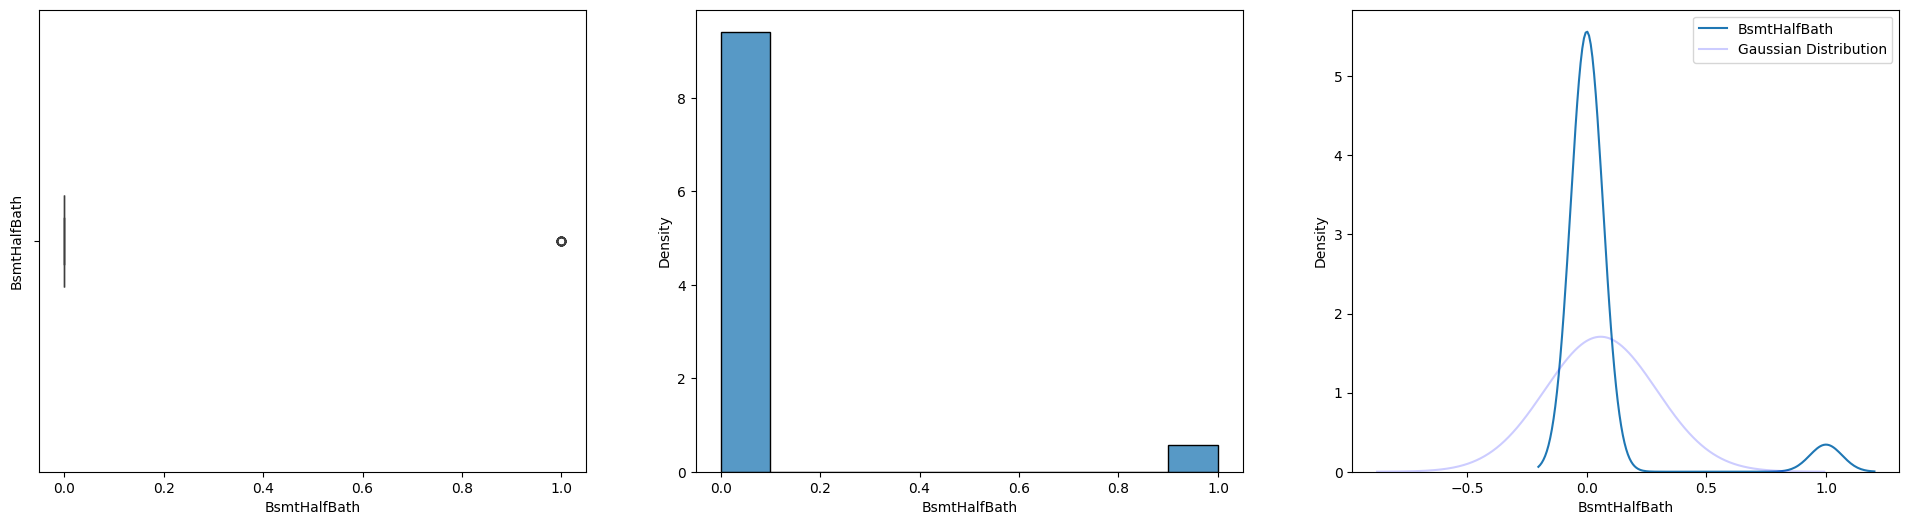

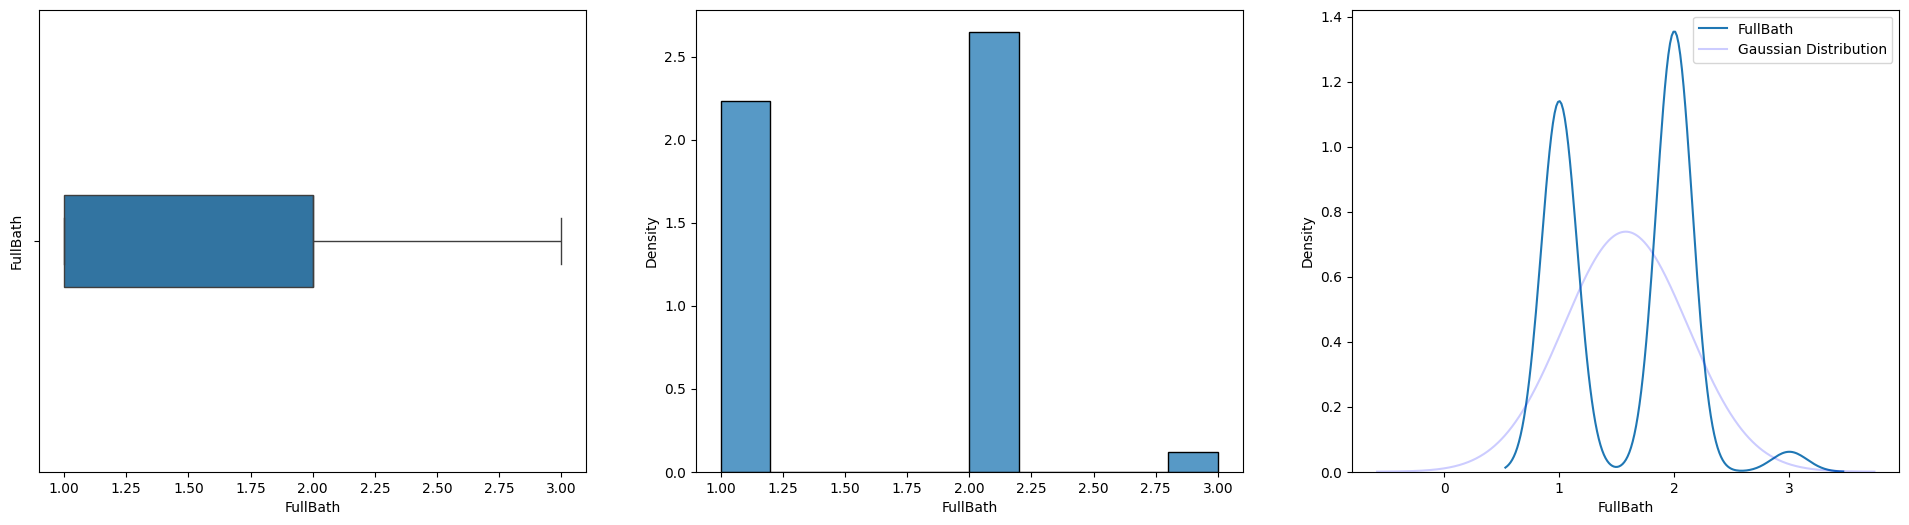

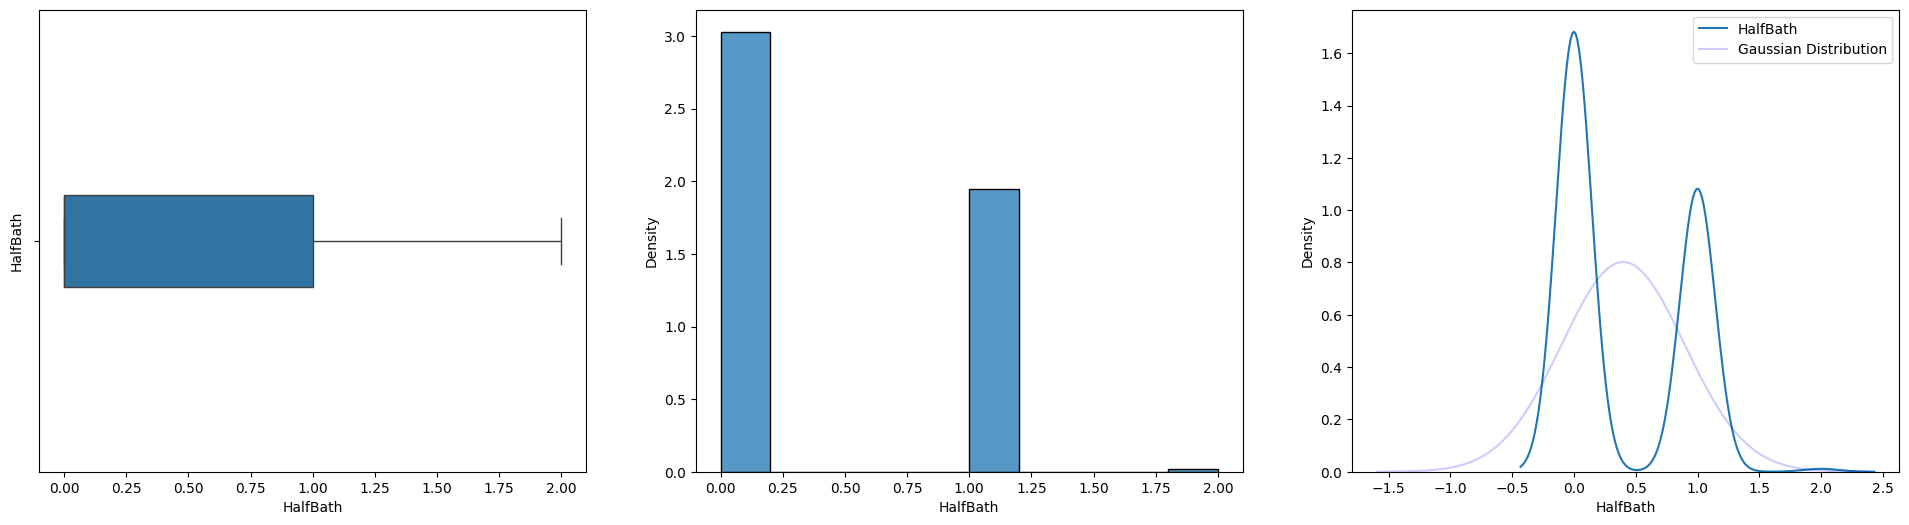

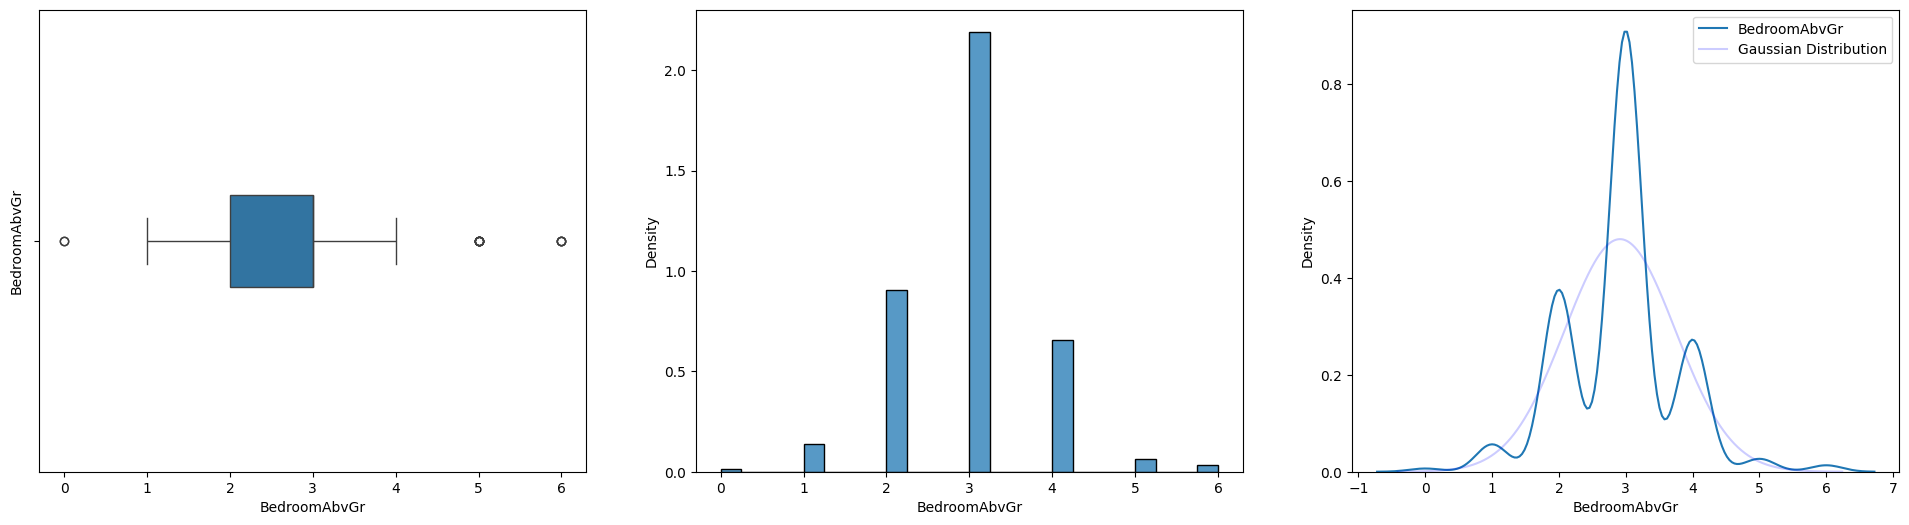

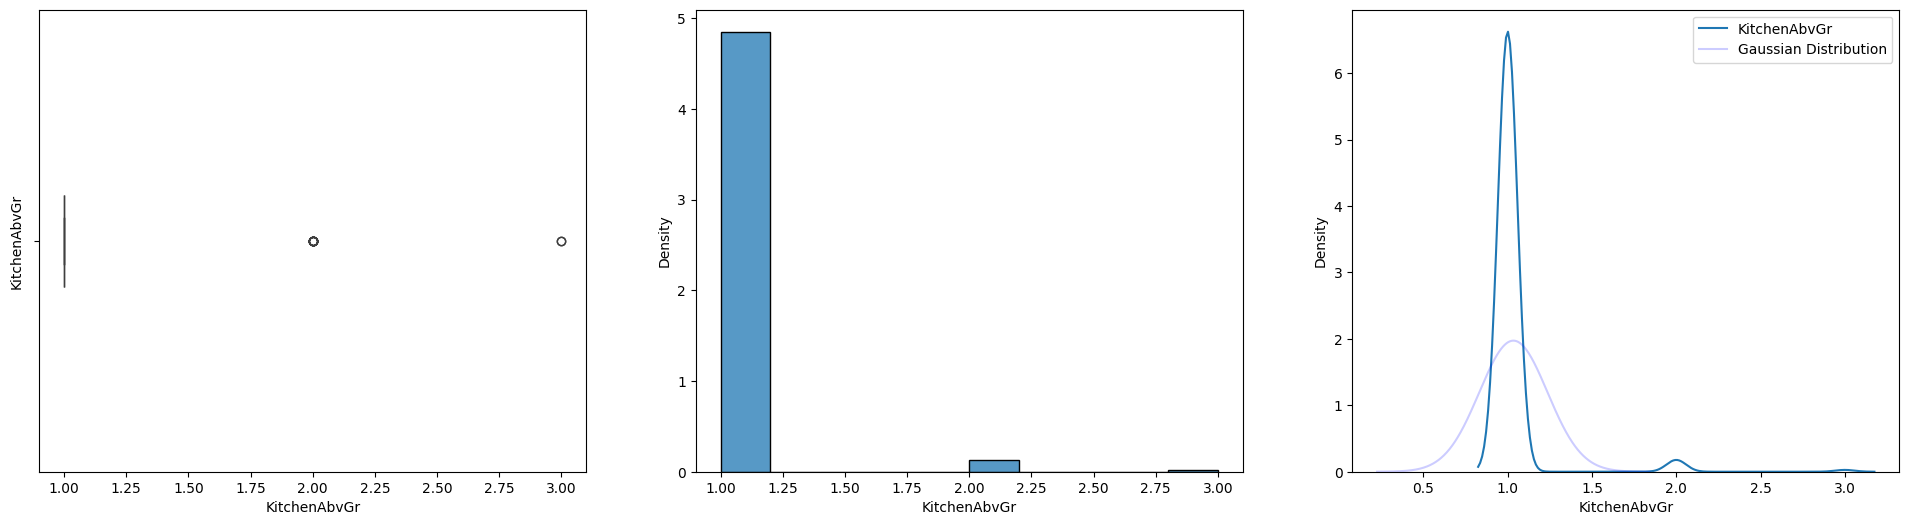

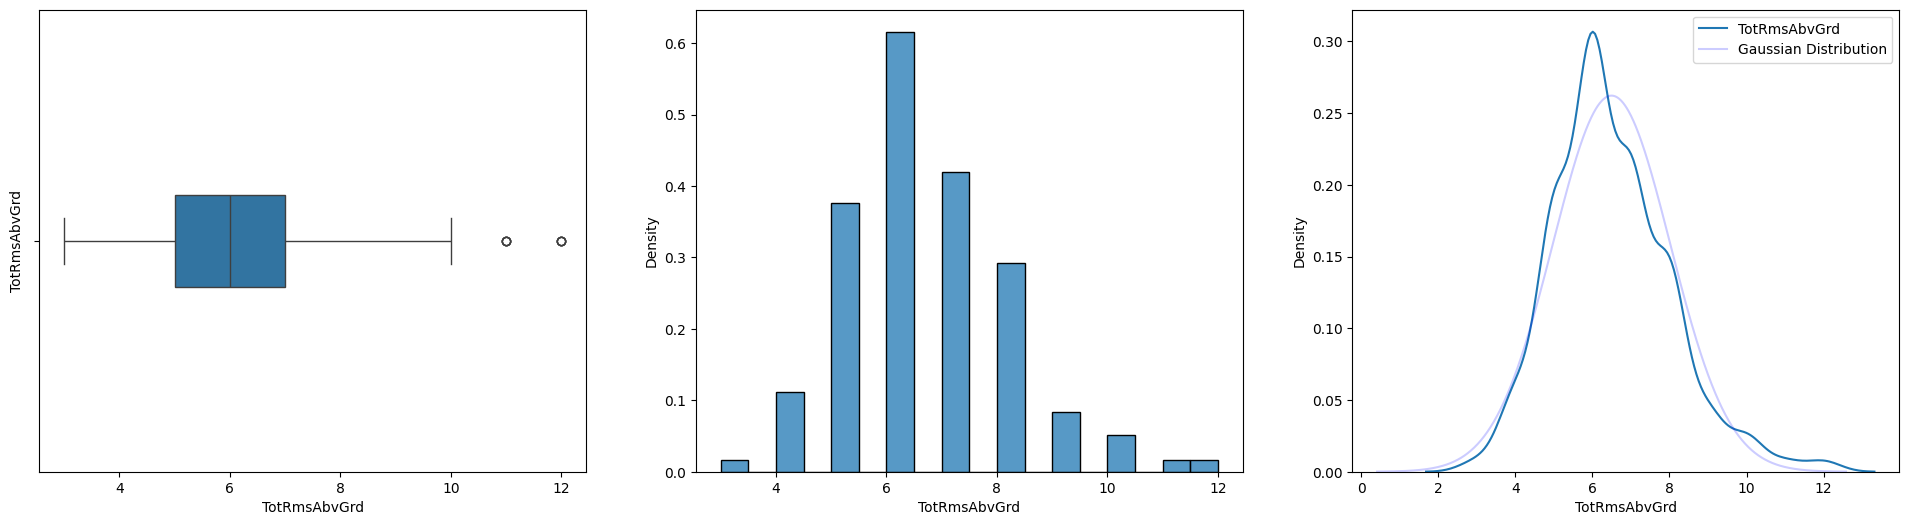

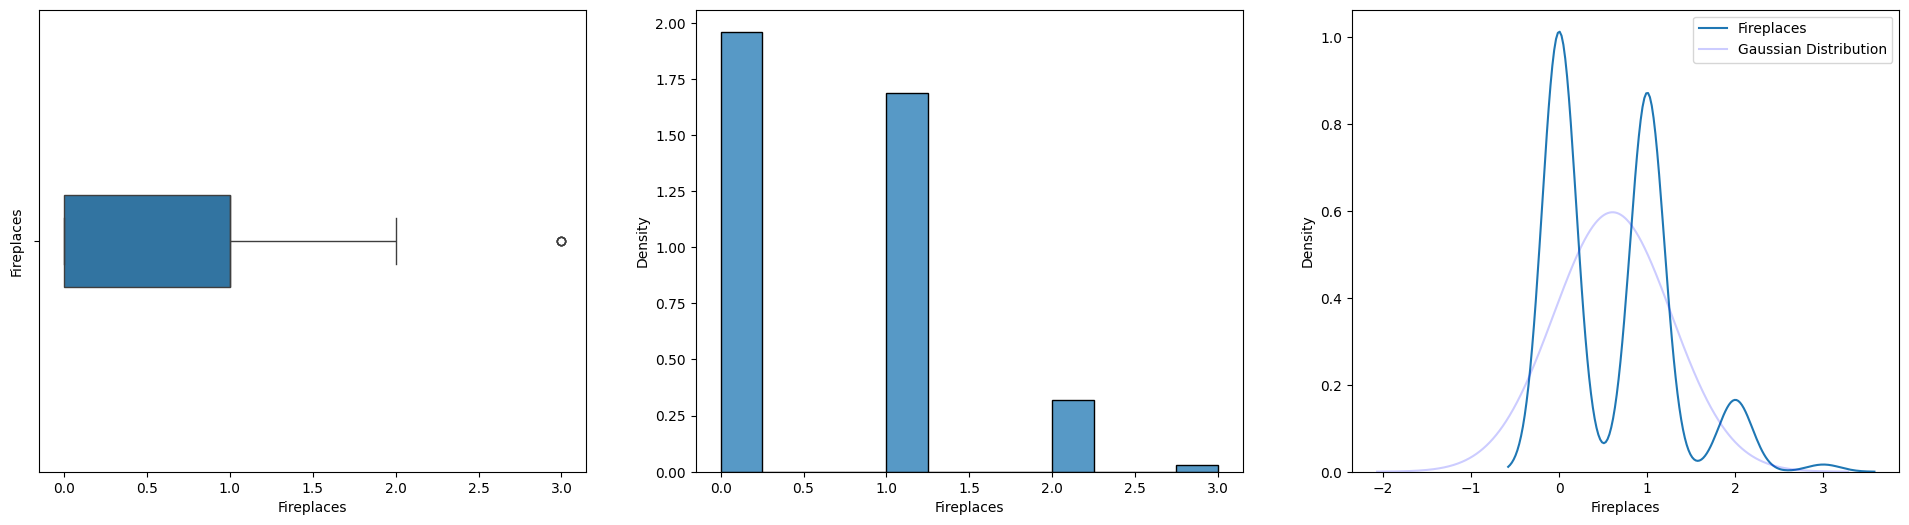

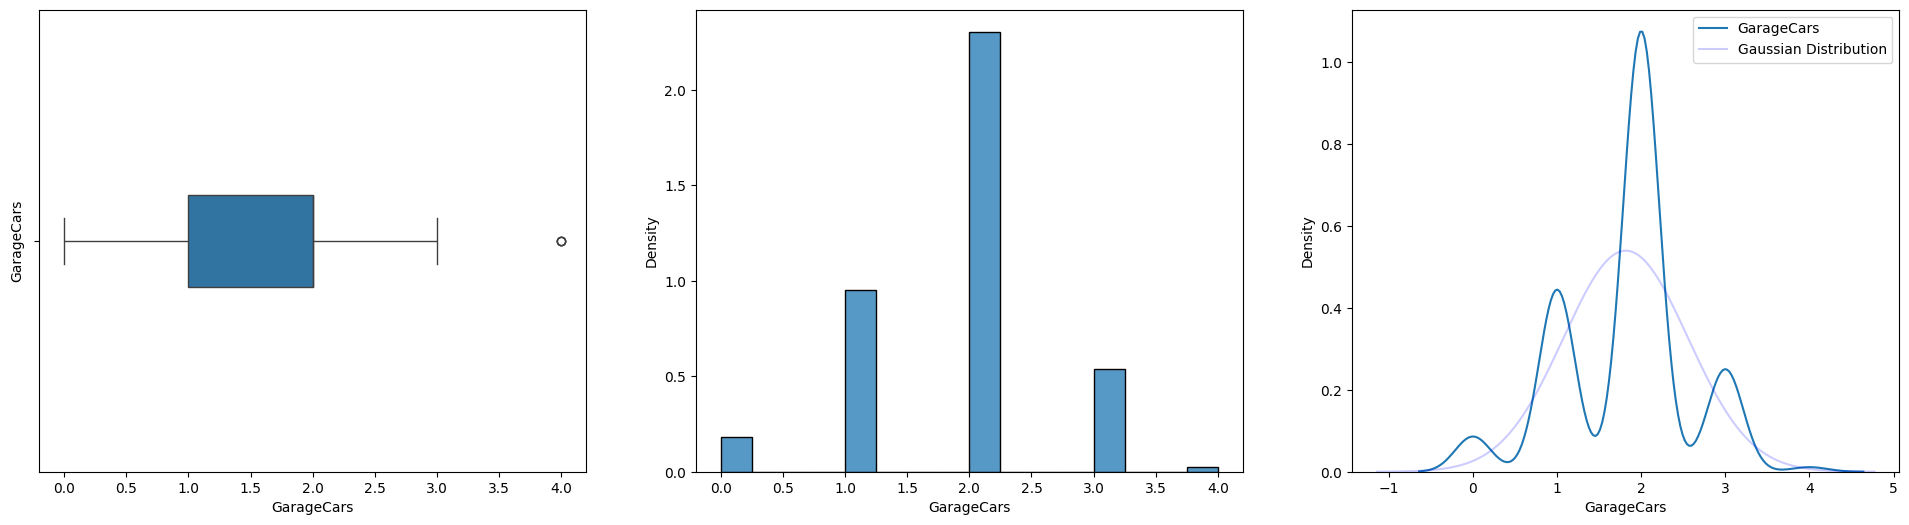

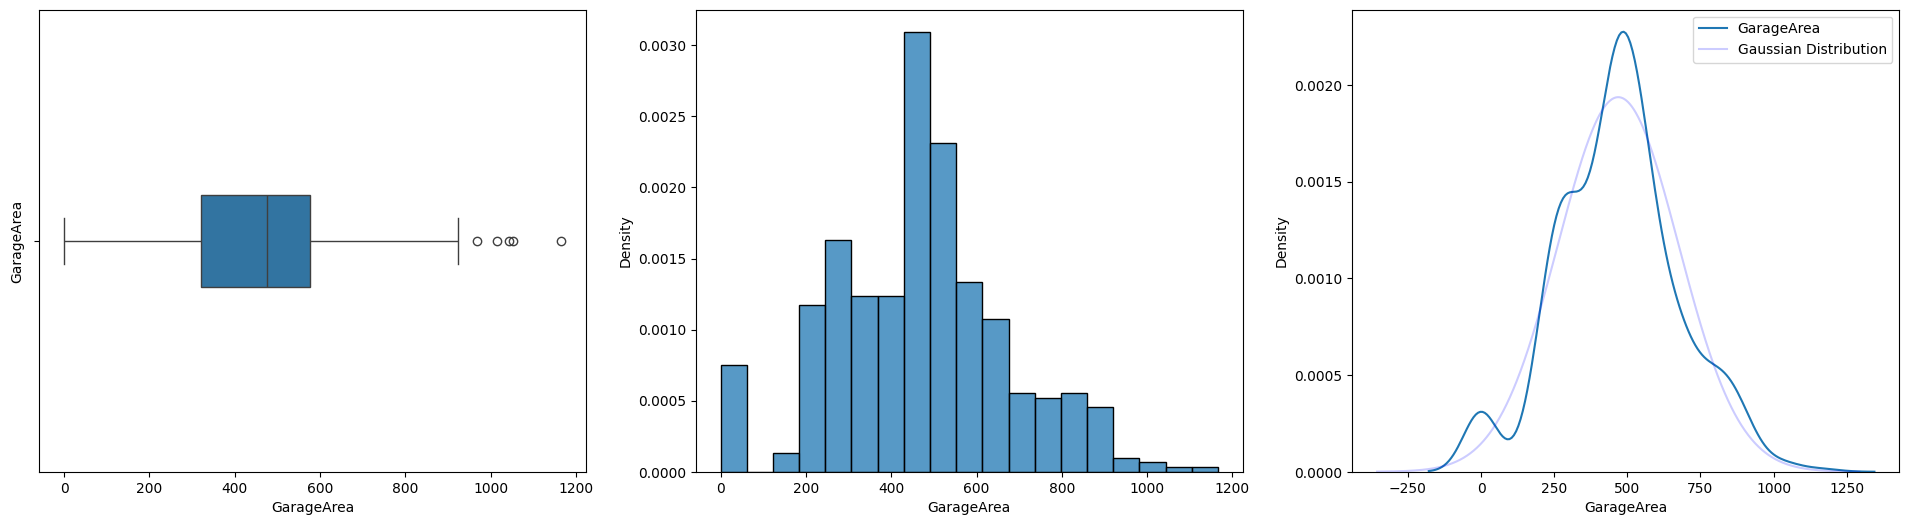

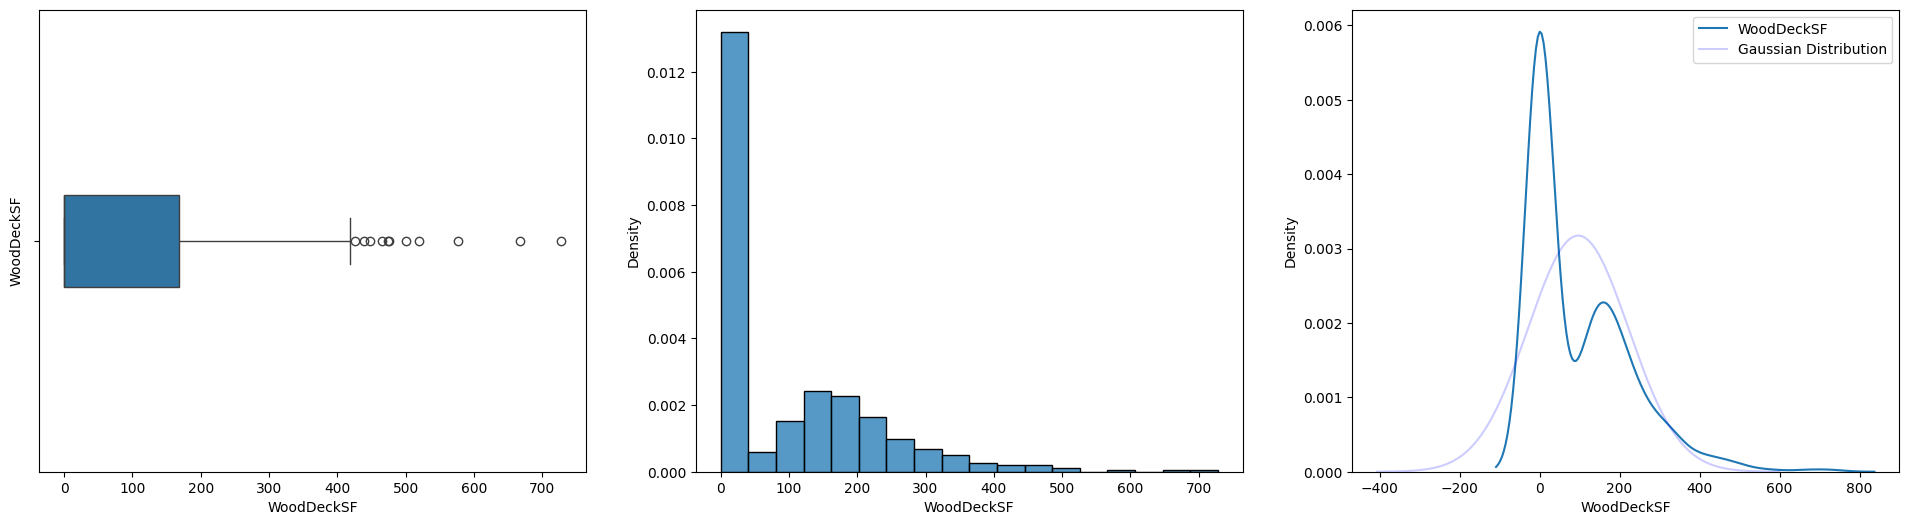

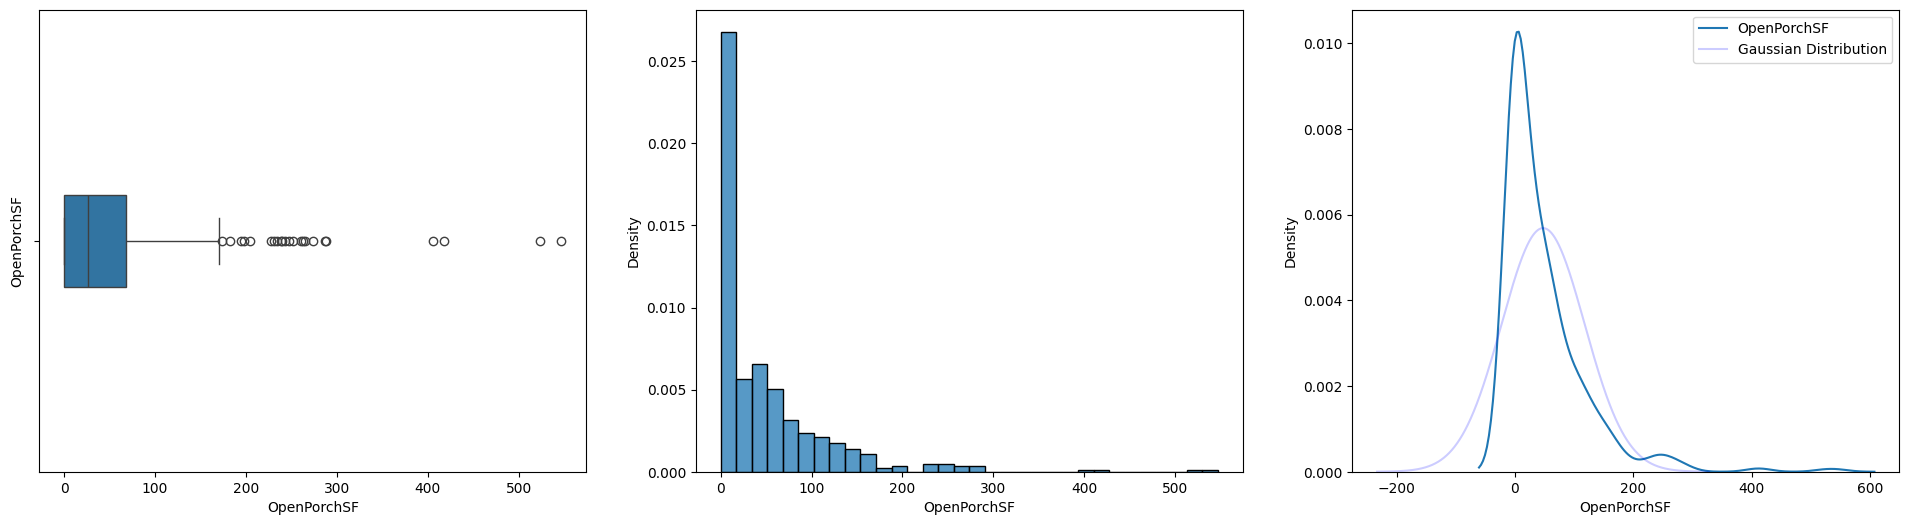

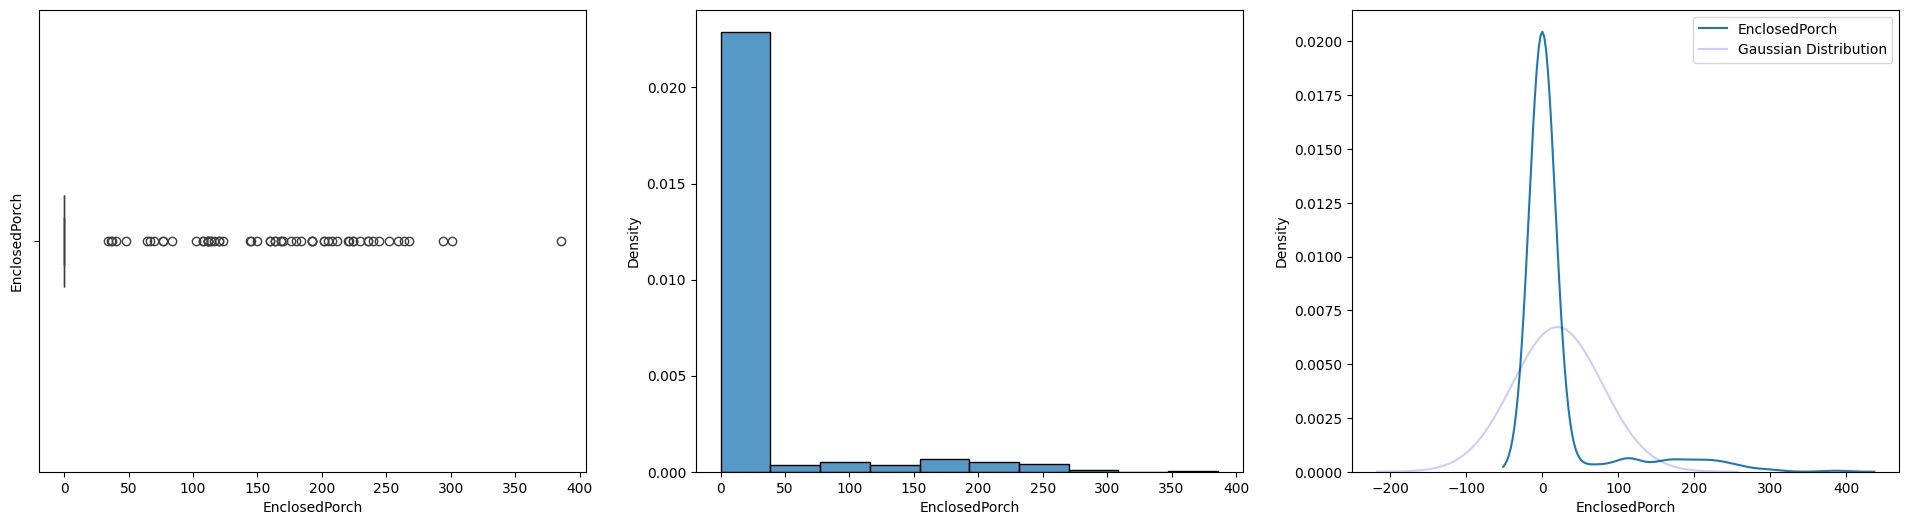

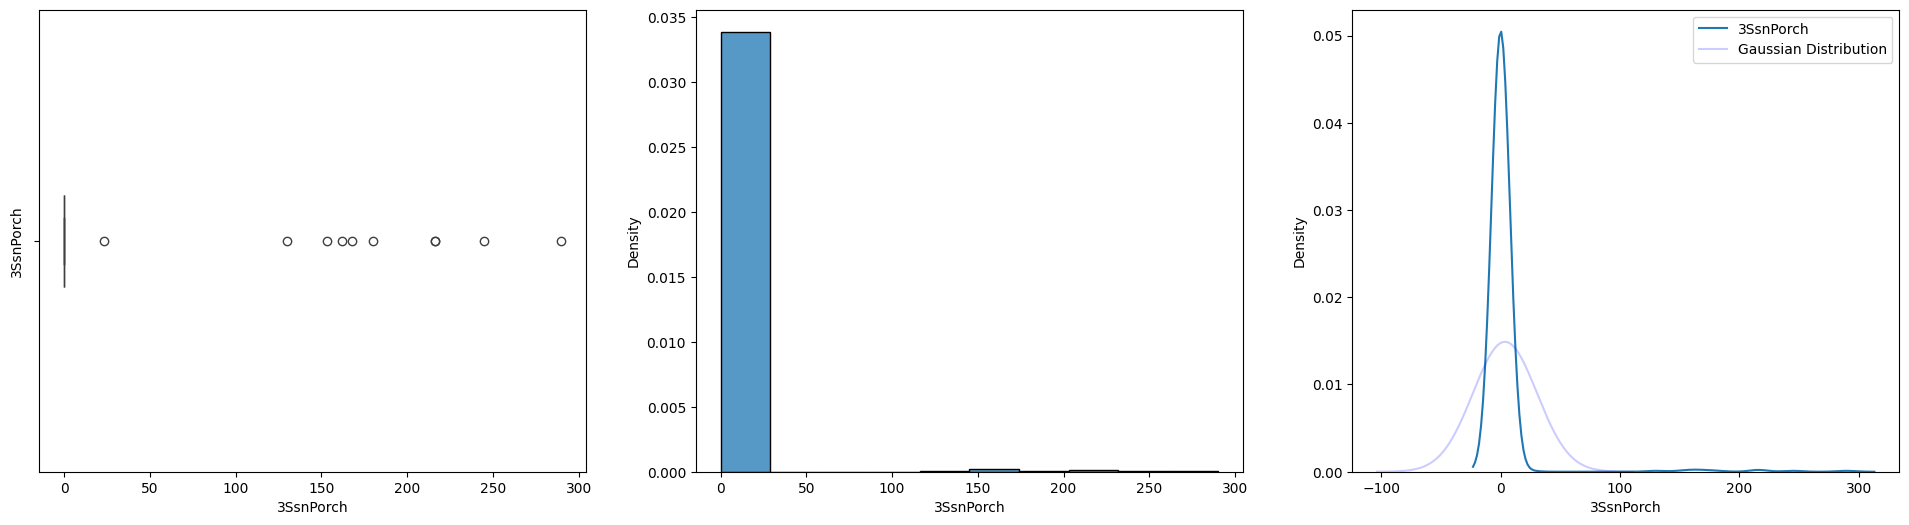

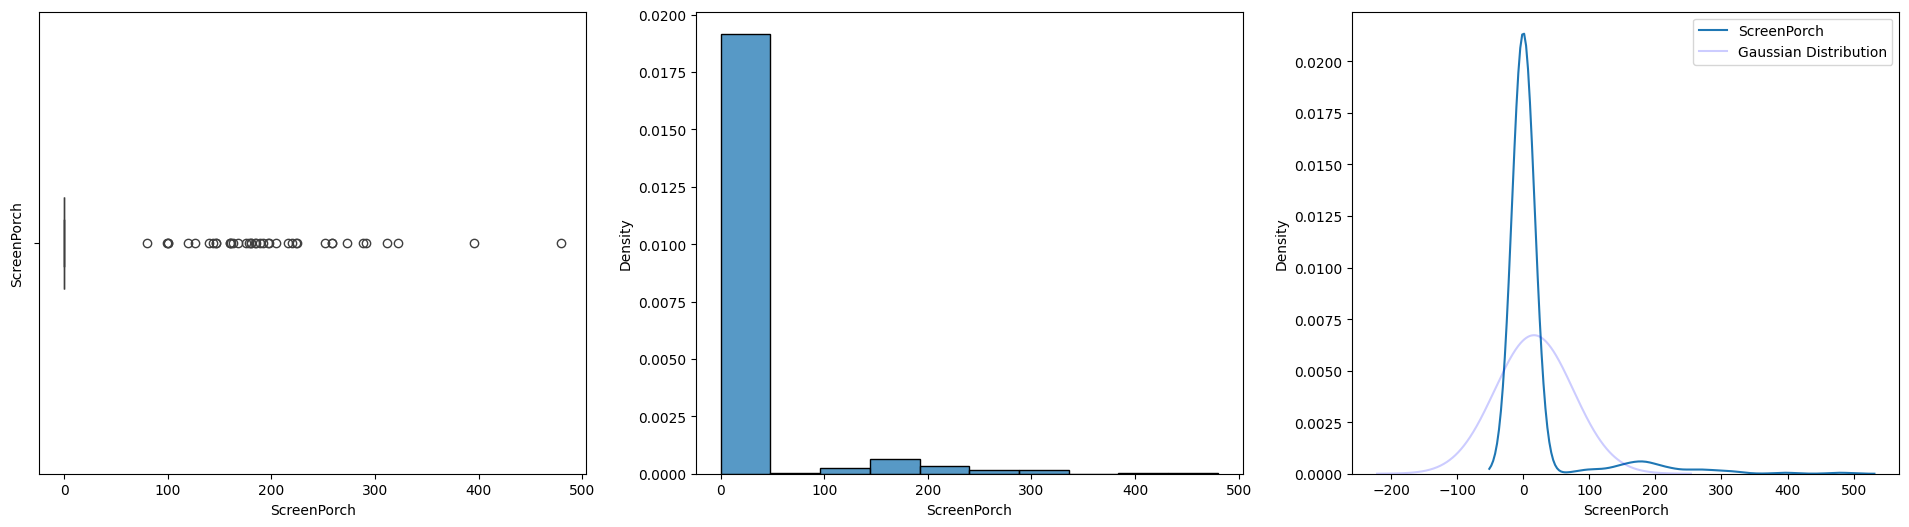

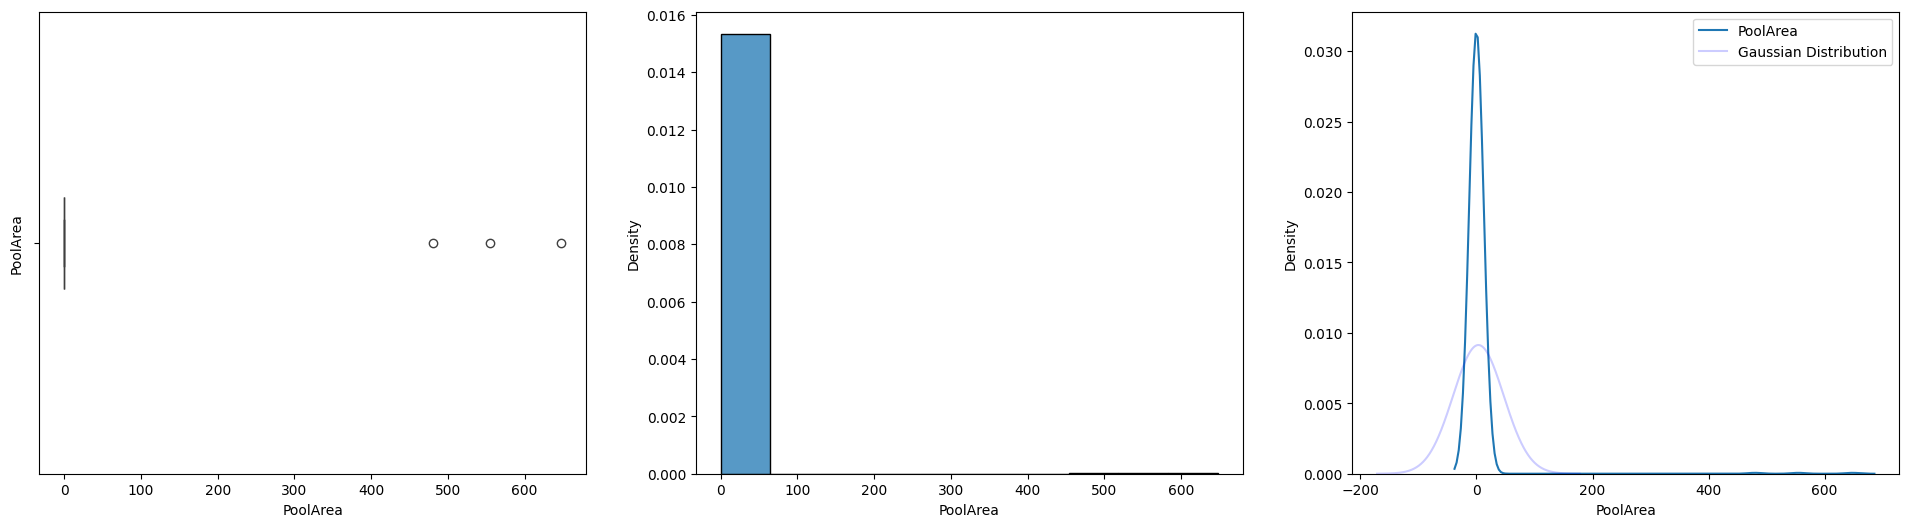

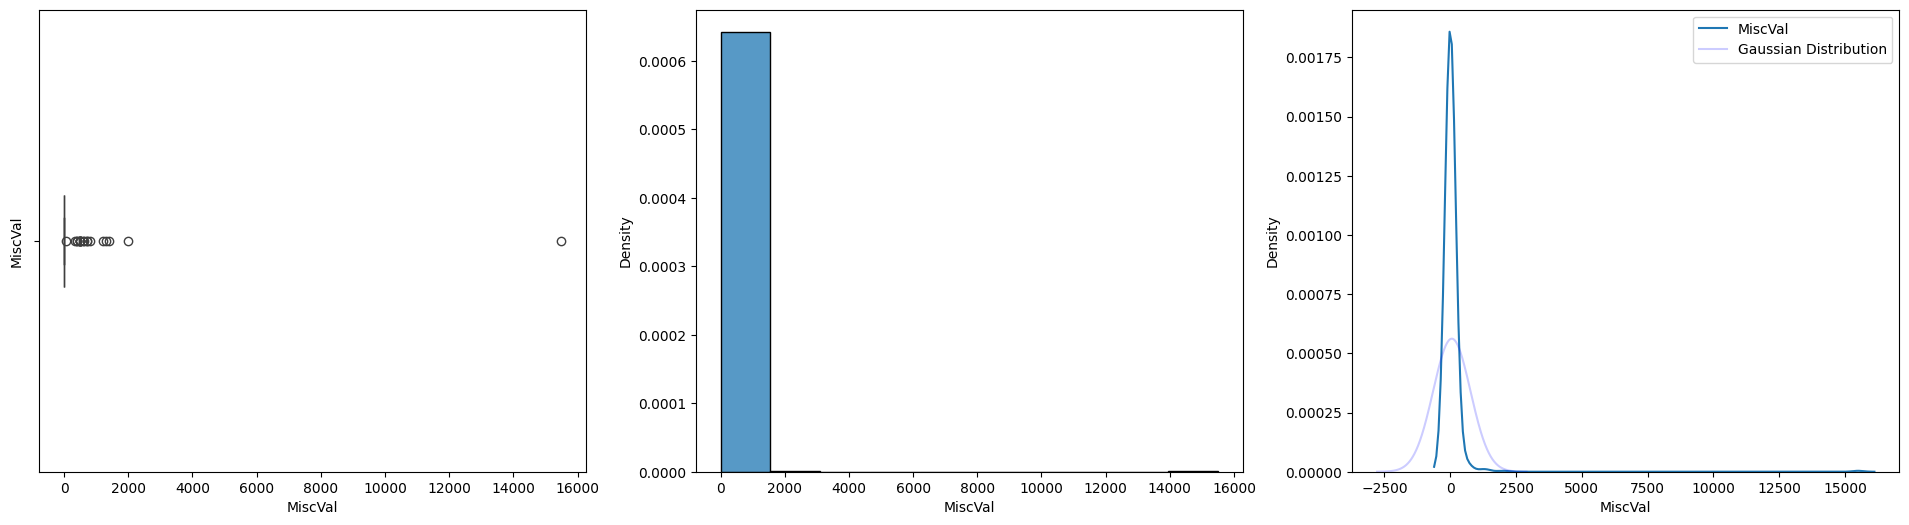

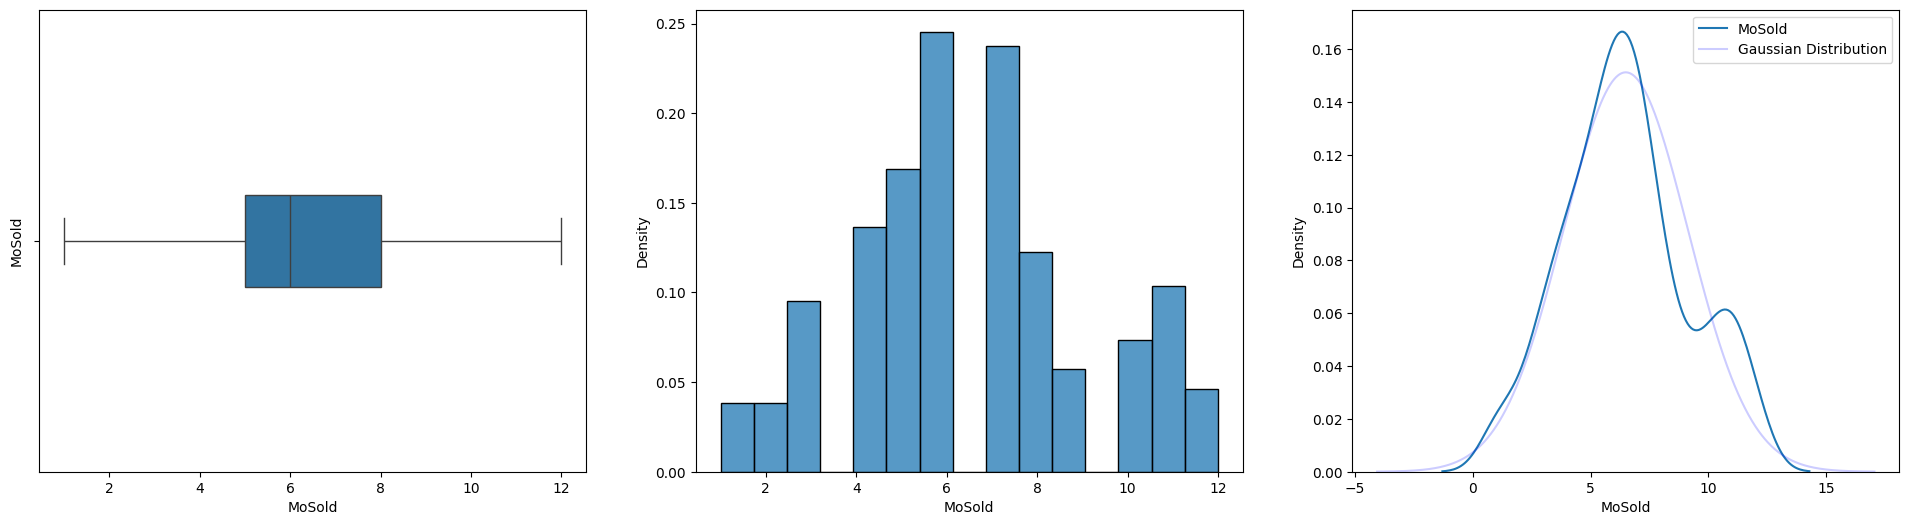

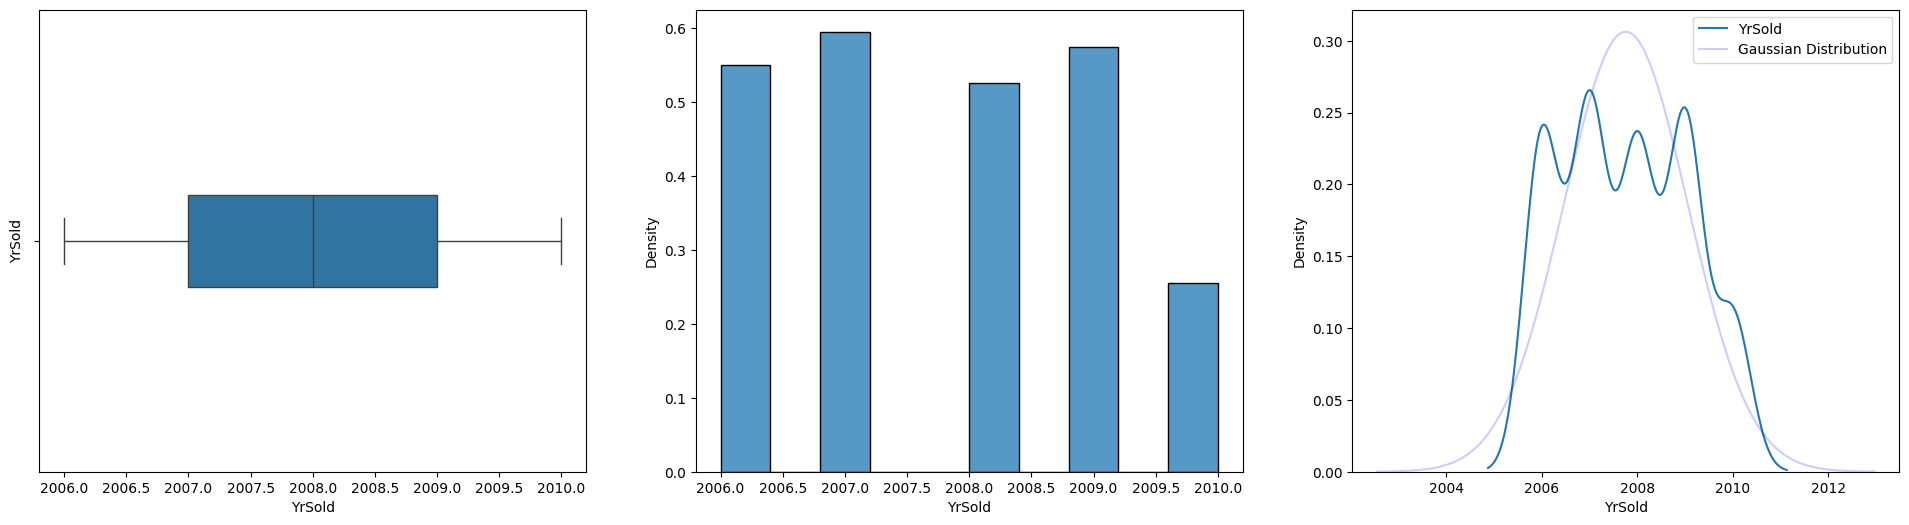

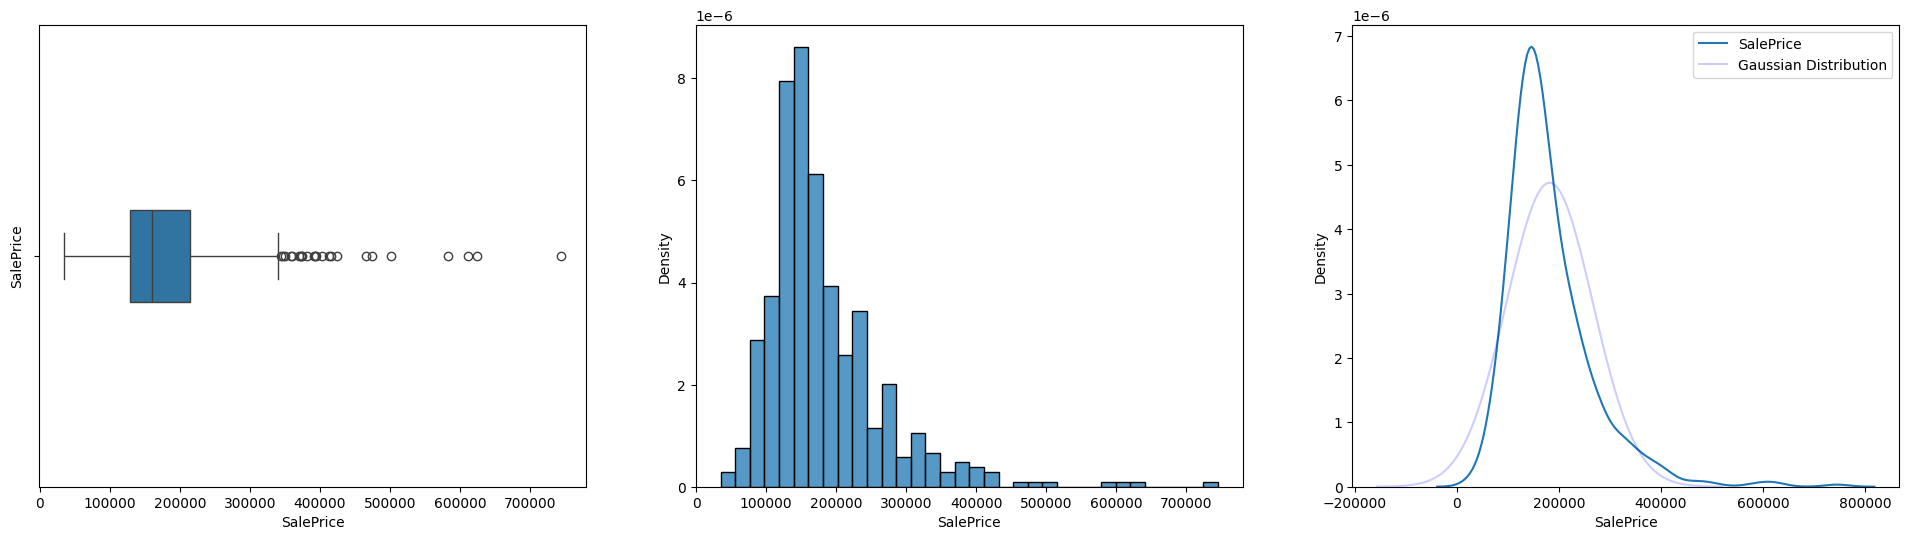

In [76]:
for col in clean_df.select_dtypes(include='number').columns:
    EDA_feat(clean_df[col], sample=500)

In [77]:
from scipy.stats import zscore

def counting_outliers(df, how='IQR'):
    if how == 'IQR':
        for col in raw_df.columns:
            Q3 = df[col].quantile(0.75)
            Q1 = df[col].quantile(0.25)
            IQR = Q3 - Q1
            outliers = df.loc[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
            print(f'Outliers for the feature {col} = {len(outliers)}')
    if how == '3sigma':
        for col in raw_df.columns:
            outliers = raw_df.loc[abs(zscore(raw_df[col])) > 3, col]
            print(f'Outliers for the feature {col} = {len(outliers)}')


def removing_outliers(df, how='IQR'):
    out_df = df
    if how == 'IQR':
        for col in out_df.columns:
            Q3 = df[col].quantile(0.75)
            Q1 = df[col].quantile(0.25)
            IQR = Q3 - Q1
            out_df = out_df.loc[(out_df[col] > Q1 - 1.5*IQR) & (out_df[col] < Q3 + 1.5*IQR)]
        return out_df
    
    if how == '3sigma':
        for col in out_df.columns:
            out_df = out_df.loc[abs(zscore(out_df[col])) < 3]
        return out_df

In [78]:
out_IQR = removing_outliers(clean_df.select_dtypes(include='number'), how='IQR')
out_3sigma = removing_outliers(clean_df.select_dtypes(include='number'), how='3sigma')


print(f'The number of rows dropped statistically if we remove outliers using IQR is {len(clean_df) - len(out_IQR)}. This is {round(100 - len(out_IQR)/len(clean_df)*100, 1)} % of the dataset')
print(f'The number of rows dropped statistically if we remove outliers out of 3 standard deviations is {len(clean_df) - len(out_3sigma)}. This is {round(100 - len(out_3sigma)/len(clean_df)*100, 1)} % of the dataset')

The number of rows dropped statistically if we remove outliers using IQR is 1460. This is 100.0 % of the dataset
The number of rows dropped statistically if we remove outliers out of 3 standard deviations is 1460. This is 100.0 % of the dataset


In [67]:
out_IQR

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice


## Scaling

## Balancing

## Feature Correlation

## Feature Engineering

### Encoding

### Discretization

### New Feature Creation

### Bonus: Cycling Features (Time)

## Feature Selection